In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn import metrics
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import joblib

In [2]:
df = pd.read_csv("weatherAUS.csv")
pd.set_option("display.max_columns", None)
df

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0       2008-12-01   Albury     13.4     22.9       0.6          NaN   
1       2008-12-02   Albury      7.4     25.1       0.0          NaN   
2       2008-12-03   Albury     12.9     25.7       0.0          NaN   
3       2008-12-04   Albury      9.2     28.0       0.0          NaN   
4       2008-12-05   Albury     17.5     32.3       1.0          NaN   
...            ...      ...      ...      ...       ...          ...   
145455  2017-06-21    Uluru      2.8     23.4       0.0          NaN   
145456  2017-06-22    Uluru      3.6     25.3       0.0          NaN   
145457  2017-06-23    Uluru      5.4     26.9       0.0          NaN   
145458  2017-06-24    Uluru      7.8     27.0       0.0          NaN   
145459  2017-06-25    Uluru     14.9      NaN       0.0          NaN   

        Sunshine WindGustDir  WindGustSpeed WindDir9am WindDir3pm  \
0            NaN           W           44.0          W        WNW   
1            NaN         WNW           44.0        NNW        WSW   
2            NaN         WSW           46.0          W        WSW   
3            NaN          NE           24.0         SE          E   
4            NaN           W           41.0        ENE         NW   
...          ...         ...            ...        ...        ...   
145455       NaN           E           31.0         SE        ENE   
145456       NaN         NNW           22.0         SE          N   
145457       NaN           N           37.0         SE        WNW   
145458       NaN          SE           28.0        SSE          N   
145459       NaN         NaN            NaN        ESE        ESE   

        WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
0               20.0          24.0         71.0         22.0       1007.7   
1                4.0          22.0         44.0         25.0       1010.6   
2               19.0          26.0         38.0         30.0       1007.6   
3               11.0           9.0         45.0         16.0       1017.6   
4                7.0          20.0         82.0         33.0       1010.8   
...              ...           ...          ...          ...          ...   
145455          13.0          11.0         51.0         24.0       1024.6   
145456          13.0           9.0         56.0         21.0       1023.5   
145457           9.0           9.0         53.0         24.0       1021.0   
145458          13.0           7.0         51.0         24.0       1019.4   
145459          17.0          17.0         62.0         36.0       1020.2   

        Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm RainToday  \
0            1007.1       8.0       NaN     16.9     21.8        No   
1            1007.8       NaN       NaN     17.2     24.3        No   
2            1008.7       NaN       2.0     21.0     23.2        No   
3            1012.8       NaN       NaN     18.1     26.5        No   
4            1006.0       7.0       8.0     17.8     29.7        No   
...             ...       ...       ...      ...      ...       ...   
145455       1020.3       NaN       NaN     10.1     22.4        No   
145456       1019.1       NaN       NaN     10.9     24.5        No   
145457       1016.8       NaN       NaN     12.5     26.1        No   
145458       1016.5       3.0       2.0     15.1     26.0        No   
145459       1017.9       8.0       8.0     15.0     20.9        No   

       RainTomorrow  
0                No  
1                No  
2                No  
3                No  
4                No  
...             ...  
145455           No  
145456           No  
145457           No  
145458           No  
145459          NaN  

[145460 rows x 23 columns]

In [3]:
numerical_feature = [feature for feature in df.columns if df[feature].dtypes != 'O']
discrete_feature=[feature for feature in numerical_feature if len(df[feature].unique())<25]
continuous_feature = [feature for feature in numerical_feature if feature not in discrete_feature]
categorical_feature = [feature for feature in df.columns if feature not in numerical_feature]
print("Numerical Features Count {}".format(len(numerical_feature)))
print("Discrete feature Count {}".format(len(discrete_feature)))
print("Continuous feature Count {}".format(len(continuous_feature)))
print("Categorical feature Count {}".format(len(categorical_feature)))

Numerical Features Count 16
Discrete feature Count 2
Continuous feature Count 14
Categorical feature Count 7


In [4]:
# Handle Missing Values
df.isnull().sum()*100/len(df)

Date              0.000000
Location          0.000000
MinTemp           1.020899
MaxTemp           0.866905
Rainfall          2.241853
Evaporation      43.166506
Sunshine         48.009762
WindGustDir       7.098859
WindGustSpeed     7.055548
WindDir9am        7.263853
WindDir3pm        2.906641
WindSpeed9am      1.214767
WindSpeed3pm      2.105046
Humidity9am       1.824557
Humidity3pm       3.098446
Pressure9am      10.356799
Pressure3pm      10.331363
Cloud9am         38.421559
Cloud3pm         40.807095
Temp9am           1.214767
Temp3pm           2.481094
RainToday         2.241853
RainTomorrow      2.245978
dtype: float64

In [5]:
print(numerical_feature)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


In [6]:
def randomsampleimputation(df, variable):
    df[variable]=df[variable]
    random_sample=df[variable].dropna().sample(df[variable].isnull().sum(),random_state=0)
    random_sample.index=df[df[variable].isnull()].index
    df.loc[df[variable].isnull(),variable]=random_sample

In [7]:
randomsampleimputation(df, "Cloud9am")
randomsampleimputation(df, "Cloud3pm")
randomsampleimputation(df, "Evaporation")
randomsampleimputation(df, "Sunshine")

In [8]:
df

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0       2008-12-01   Albury     13.4     22.9       0.6          2.4   
1       2008-12-02   Albury      7.4     25.1       0.0          3.6   
2       2008-12-03   Albury     12.9     25.7       0.0          2.6   
3       2008-12-04   Albury      9.2     28.0       0.0         18.4   
4       2008-12-05   Albury     17.5     32.3       1.0          5.4   
...            ...      ...      ...      ...       ...          ...   
145455  2017-06-21    Uluru      2.8     23.4       0.0          1.4   
145456  2017-06-22    Uluru      3.6     25.3       0.0          7.6   
145457  2017-06-23    Uluru      5.4     26.9       0.0          6.8   
145458  2017-06-24    Uluru      7.8     27.0       0.0          2.6   
145459  2017-06-25    Uluru     14.9      NaN       0.0          1.4   

        Sunshine WindGustDir  WindGustSpeed WindDir9am WindDir3pm  \
0            8.3           W           44.0          W        WNW   
1           10.0         WNW           44.0        NNW        WSW   
2            4.4         WSW           46.0          W        WSW   
3            8.9          NE           24.0         SE          E   
4            3.0           W           41.0        ENE         NW   
...          ...         ...            ...        ...        ...   
145455       7.8           E           31.0         SE        ENE   
145456      13.5         NNW           22.0         SE          N   
145457      11.0           N           37.0         SE        WNW   
145458      13.2          SE           28.0        SSE          N   
145459       0.7         NaN            NaN        ESE        ESE   

        WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
0               20.0          24.0         71.0         22.0       1007.7   
1                4.0          22.0         44.0         25.0       1010.6   
2               19.0          26.0         38.0         30.0       1007.6   
3               11.0           9.0         45.0         16.0       1017.6   
4                7.0          20.0         82.0         33.0       1010.8   
...              ...           ...          ...          ...          ...   
145455          13.0          11.0         51.0         24.0       1024.6   
145456          13.0           9.0         56.0         21.0       1023.5   
145457           9.0           9.0         53.0         24.0       1021.0   
145458          13.0           7.0         51.0         24.0       1019.4   
145459          17.0          17.0         62.0         36.0       1020.2   

        Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm RainToday  \
0            1007.1       8.0       0.0     16.9     21.8        No   
1            1007.8       7.0       1.0     17.2     24.3        No   
2            1008.7       8.0       2.0     21.0     23.2        No   
3            1012.8       0.0       5.0     18.1     26.5        No   
4            1006.0       7.0       8.0     17.8     29.7        No   
...             ...       ...       ...      ...      ...       ...   
145455       1020.3       1.0       1.0     10.1     22.4        No   
145456       1019.1       8.0       5.0     10.9     24.5        No   
145457       1016.8       8.0       1.0     12.5     26.1        No   
145458       1016.5       3.0       2.0     15.1     26.0        No   
145459       1017.9       8.0       8.0     15.0     20.9        No   

       RainTomorrow  
0                No  
1                No  
2                No  
3                No  
4                No  
...             ...  
145455           No  
145456           No  
145457           No  
145458           No  
145459          NaN  

[145460 rows x 23 columns]

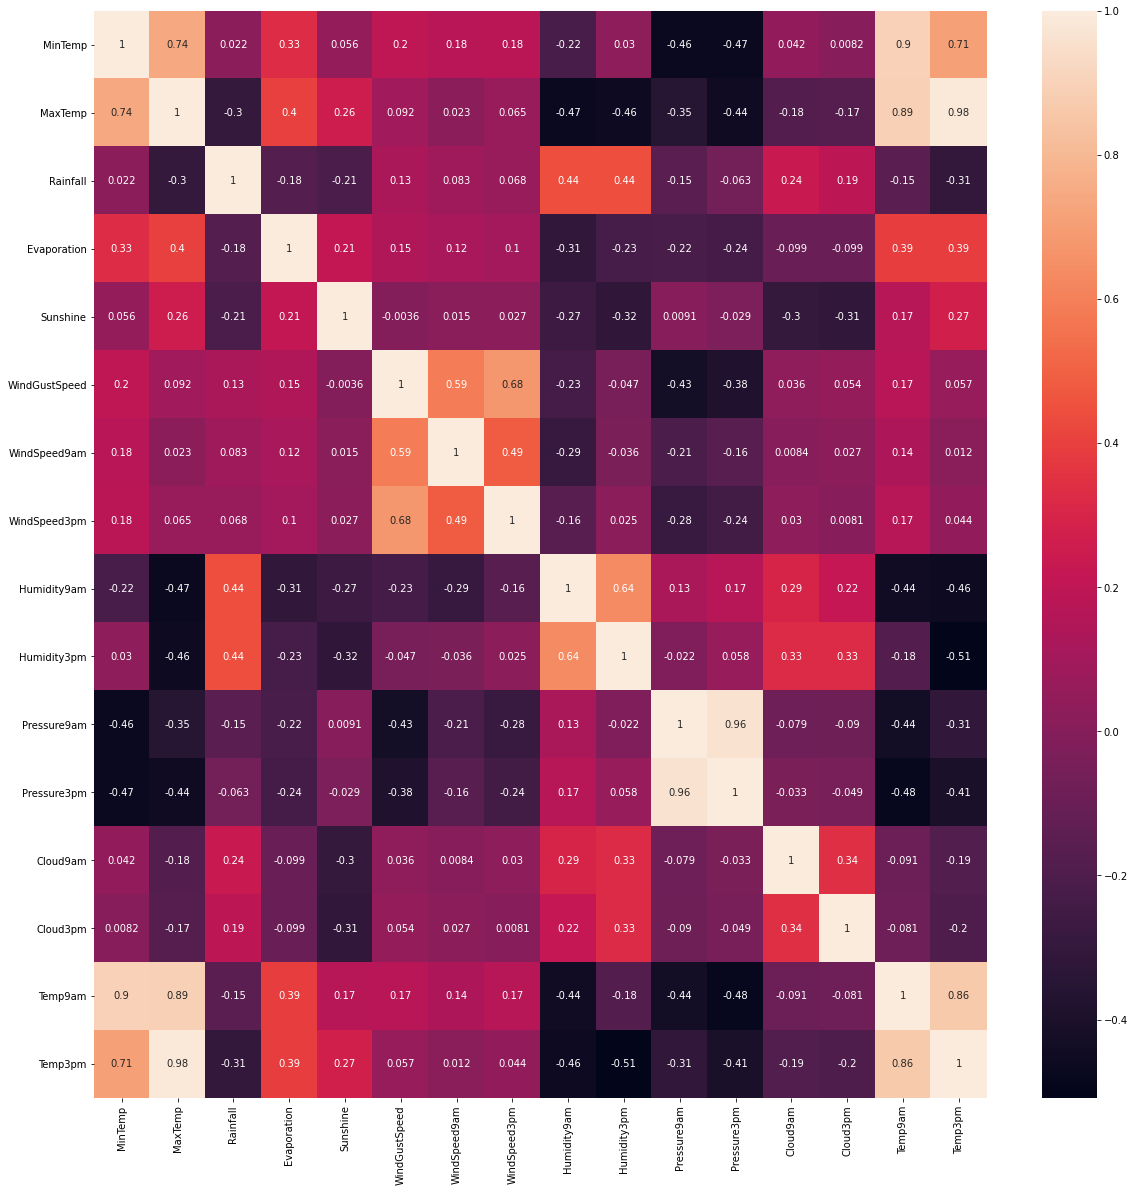

In [9]:
corrmat = df.corr(method = "spearman")
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(corrmat,annot=True)

c:\users\admin\anaconda3\envs\rainprediction\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


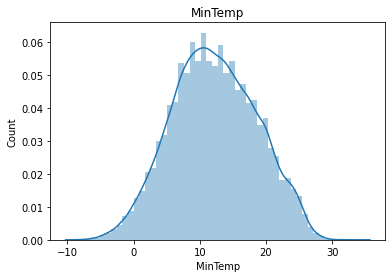

<Figure size 1080x1080 with 0 Axes>

c:\users\admin\anaconda3\envs\rainprediction\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


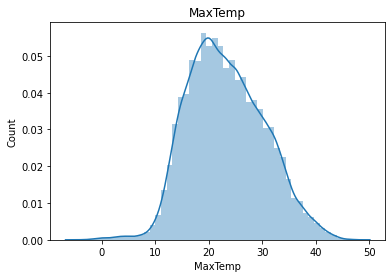

<Figure size 1080x1080 with 0 Axes>

c:\users\admin\anaconda3\envs\rainprediction\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


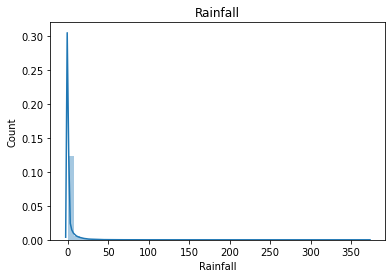

<Figure size 1080x1080 with 0 Axes>

c:\users\admin\anaconda3\envs\rainprediction\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


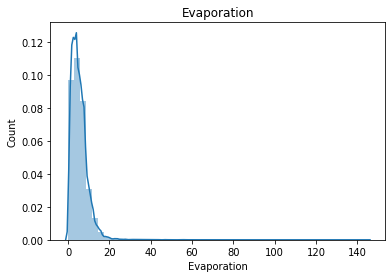

<Figure size 1080x1080 with 0 Axes>

c:\users\admin\anaconda3\envs\rainprediction\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


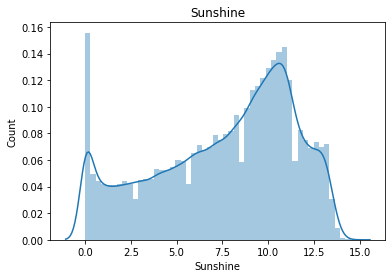

<Figure size 1080x1080 with 0 Axes>

c:\users\admin\anaconda3\envs\rainprediction\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


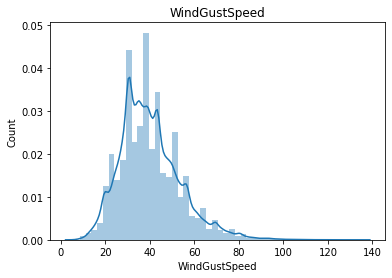

<Figure size 1080x1080 with 0 Axes>

c:\users\admin\anaconda3\envs\rainprediction\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


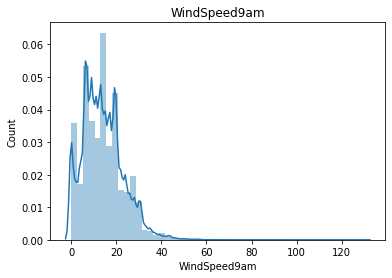

<Figure size 1080x1080 with 0 Axes>

c:\users\admin\anaconda3\envs\rainprediction\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


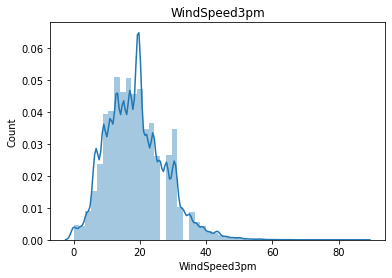

<Figure size 1080x1080 with 0 Axes>

c:\users\admin\anaconda3\envs\rainprediction\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


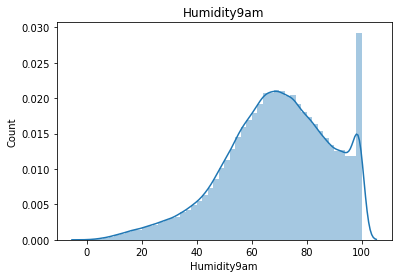

<Figure size 1080x1080 with 0 Axes>

c:\users\admin\anaconda3\envs\rainprediction\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


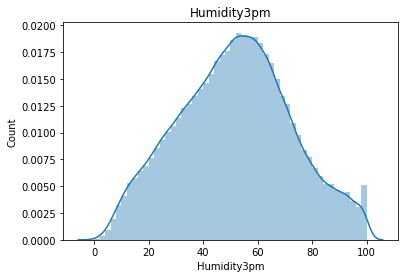

<Figure size 1080x1080 with 0 Axes>

c:\users\admin\anaconda3\envs\rainprediction\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


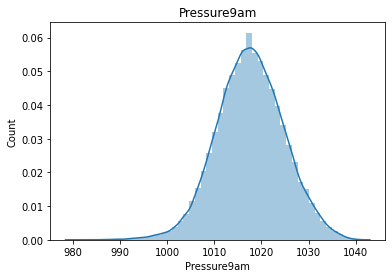

<Figure size 1080x1080 with 0 Axes>

c:\users\admin\anaconda3\envs\rainprediction\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


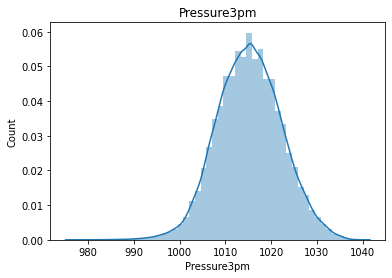

<Figure size 1080x1080 with 0 Axes>

c:\users\admin\anaconda3\envs\rainprediction\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


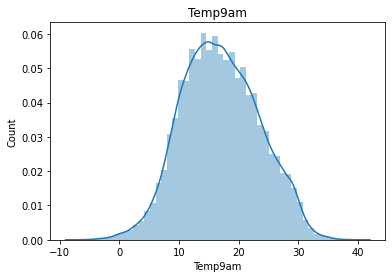

<Figure size 1080x1080 with 0 Axes>

c:\users\admin\anaconda3\envs\rainprediction\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


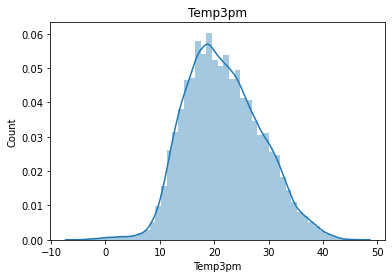

<Figure size 1080x1080 with 0 Axes>

In [10]:
for feature in continuous_feature:
    data=df.copy()
    sns.distplot(df[feature])
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.figure(figsize=(15,15))
    plt.show()

c:\users\admin\anaconda3\envs\rainprediction\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\admin\anaconda3\envs\rainprediction\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\admin\anaconda3\envs\rainprediction\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterp

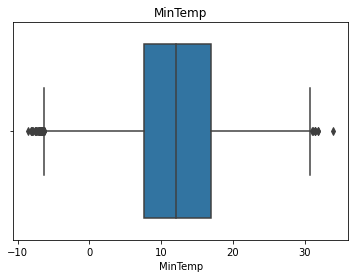

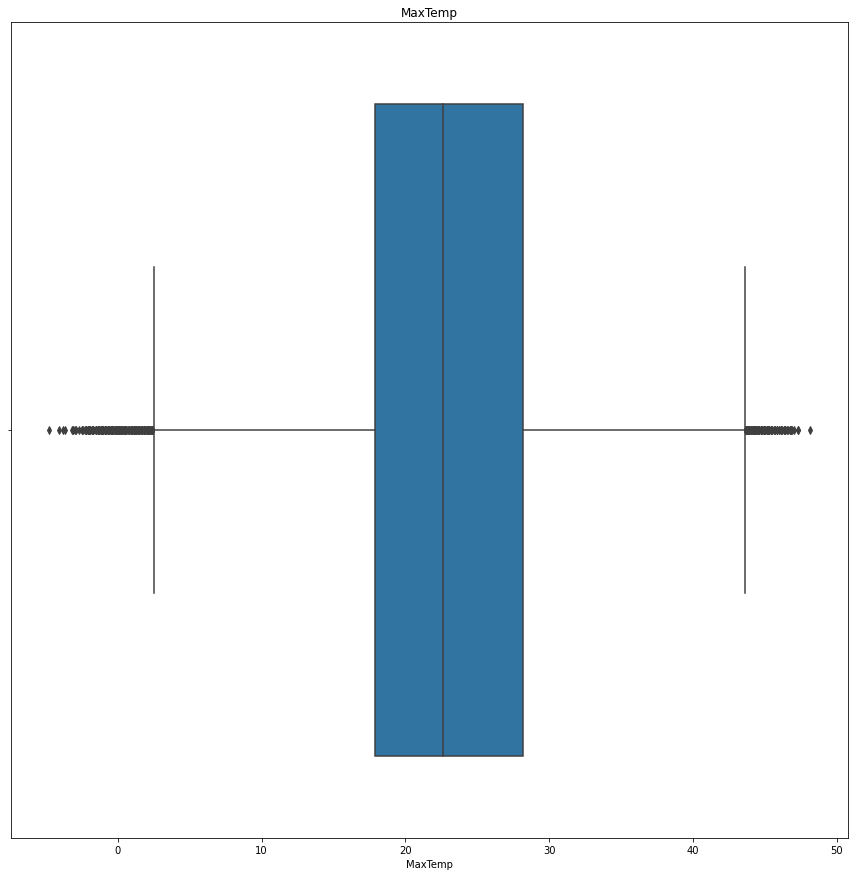

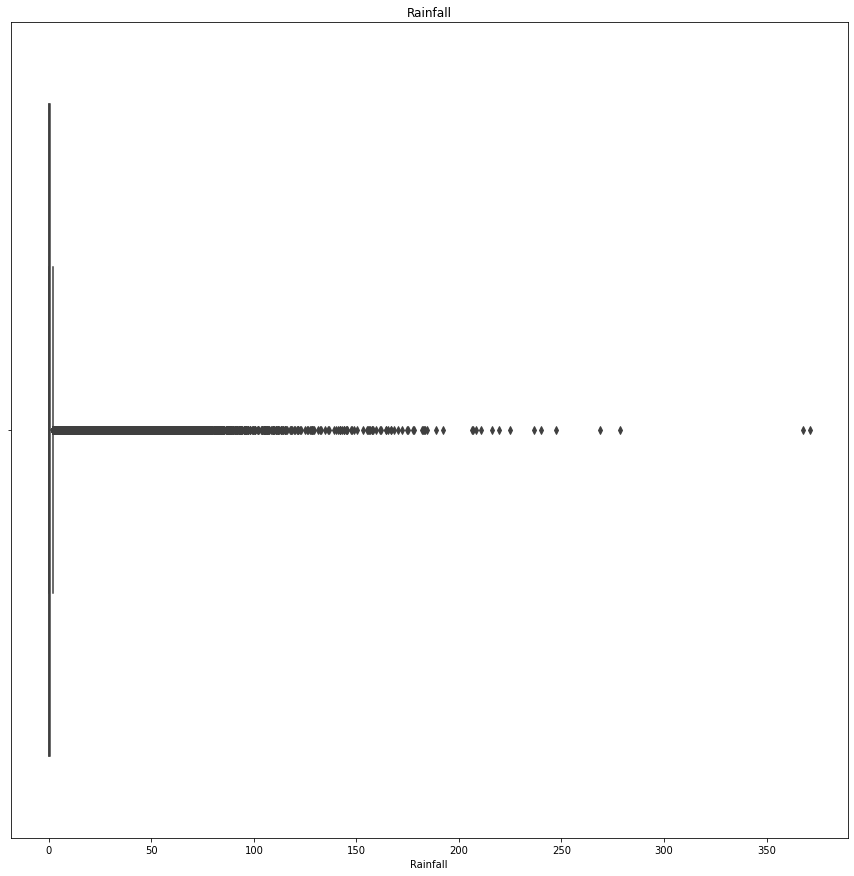

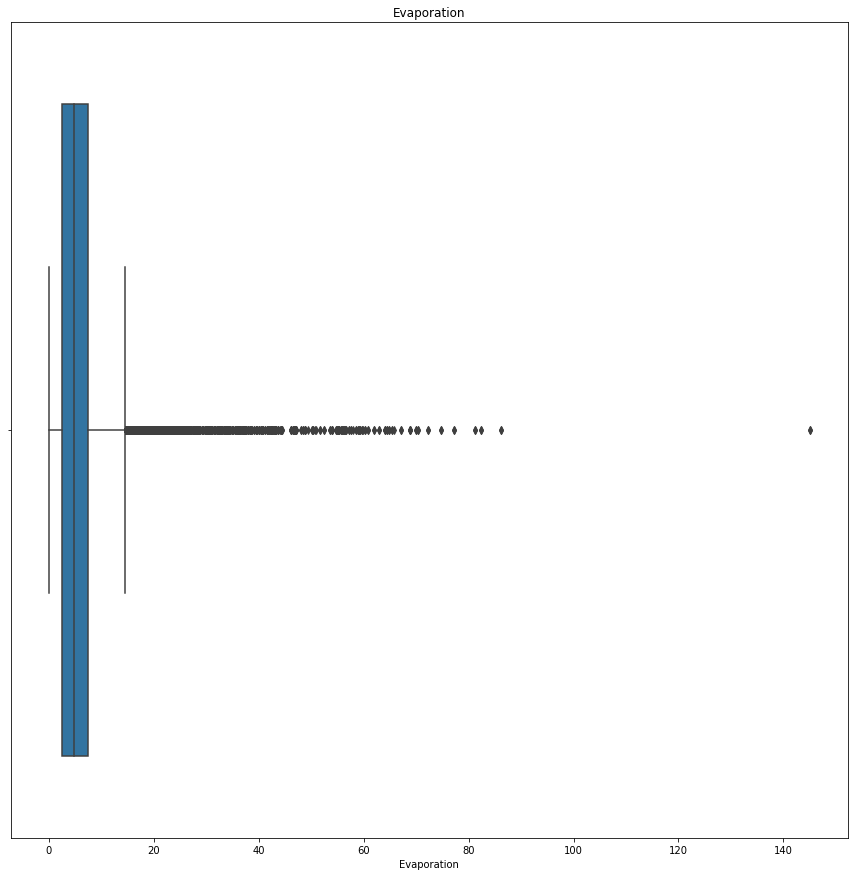

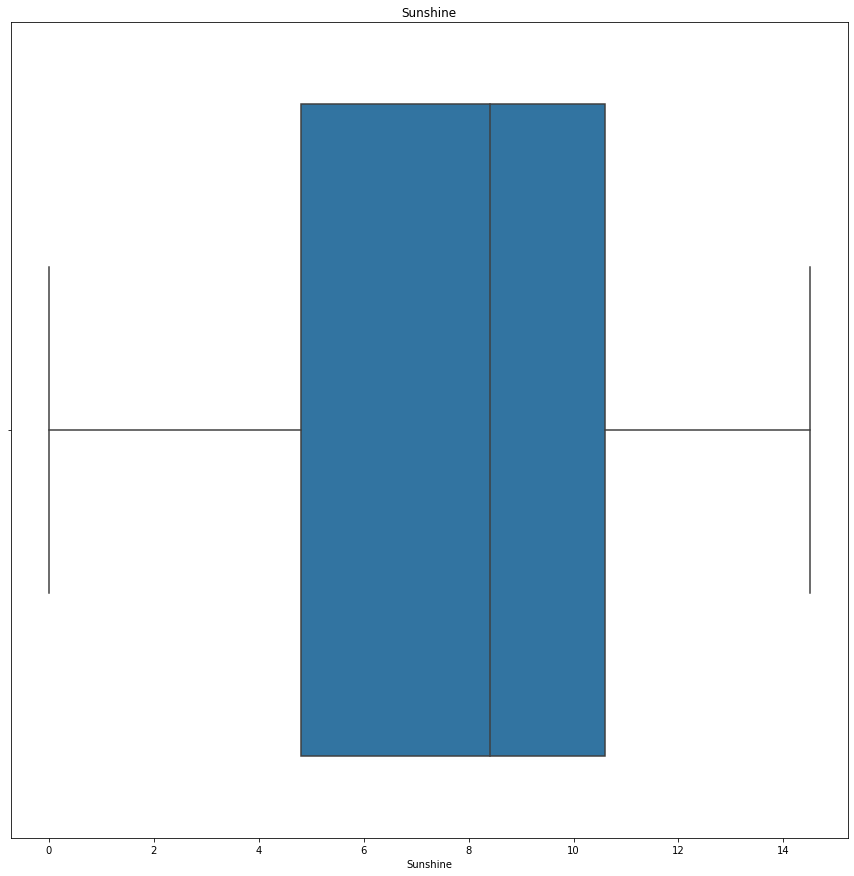

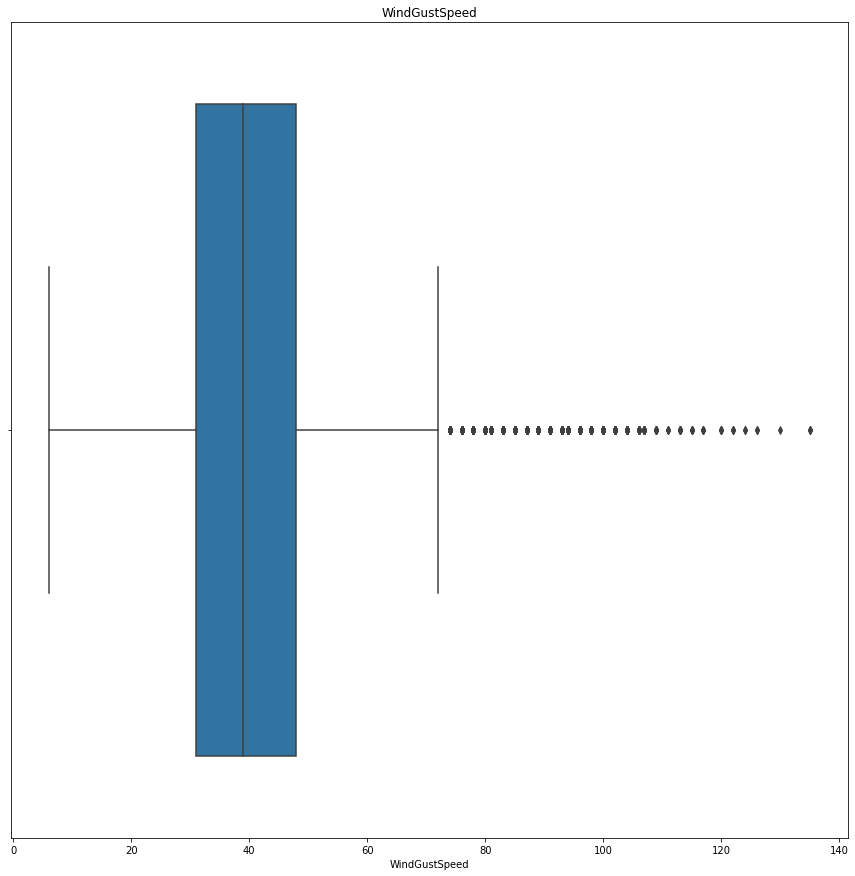

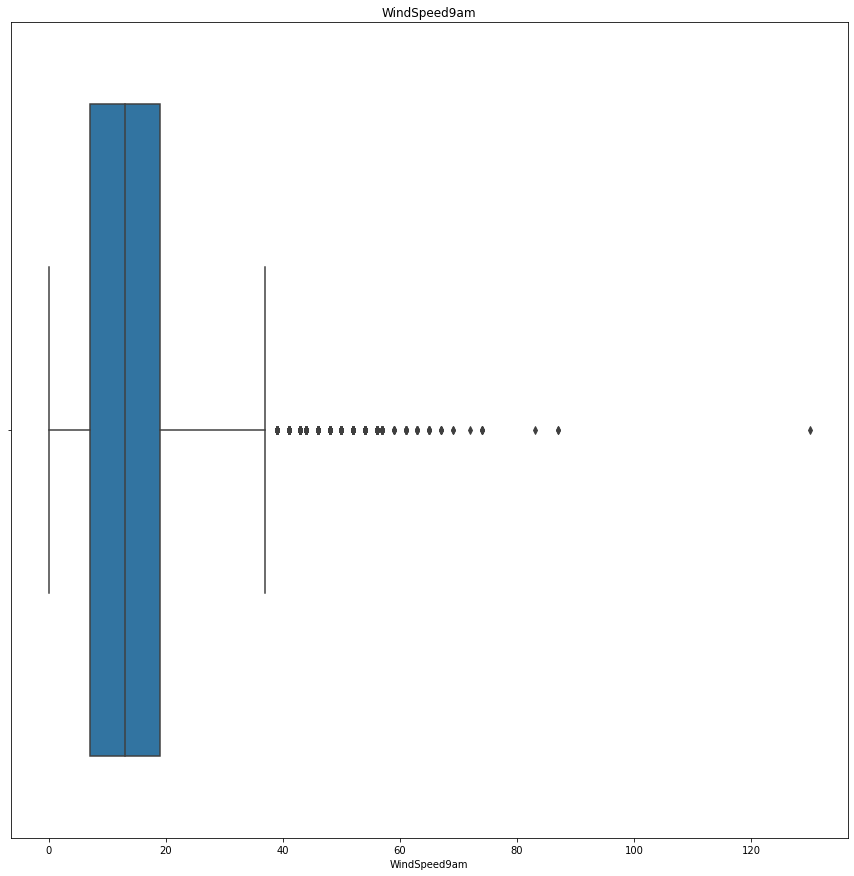

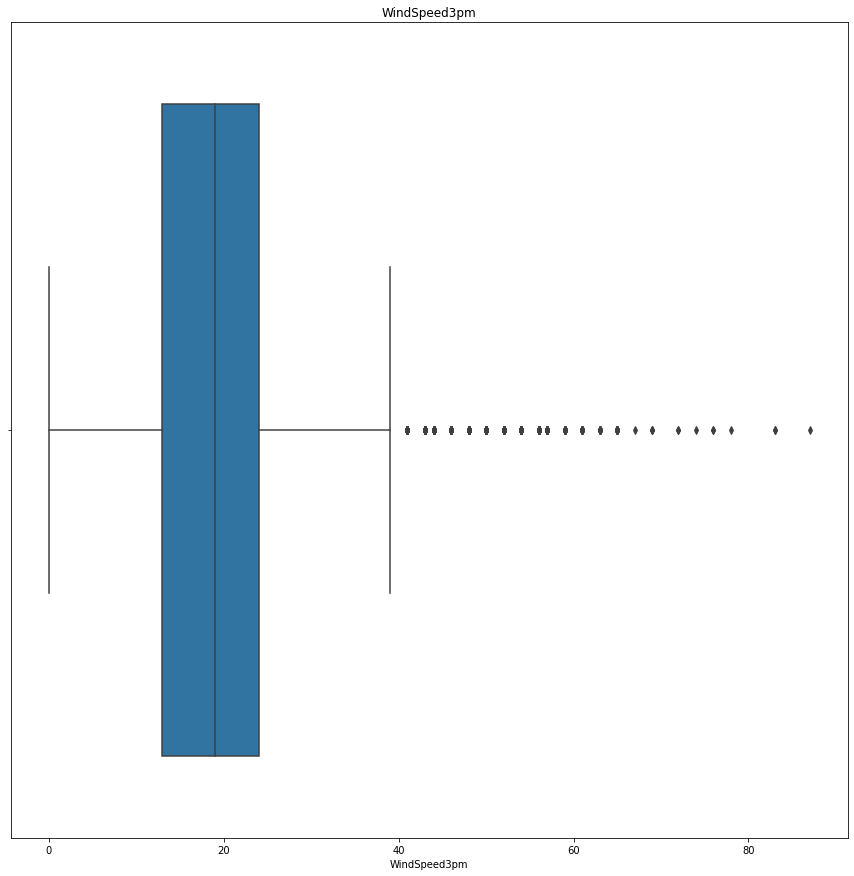

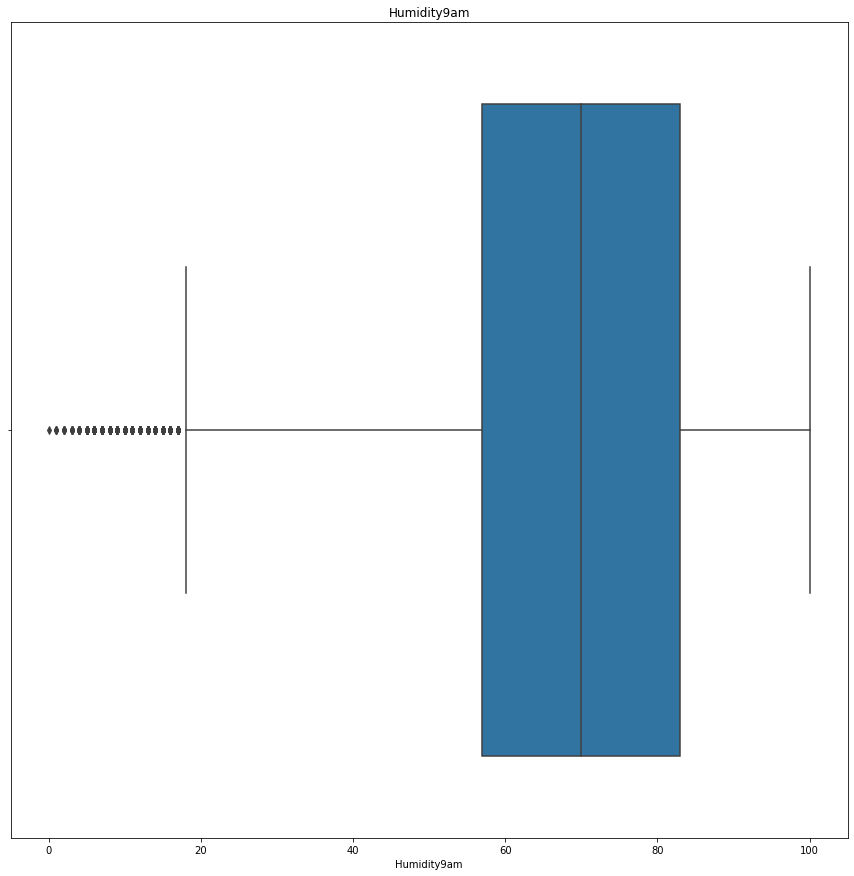

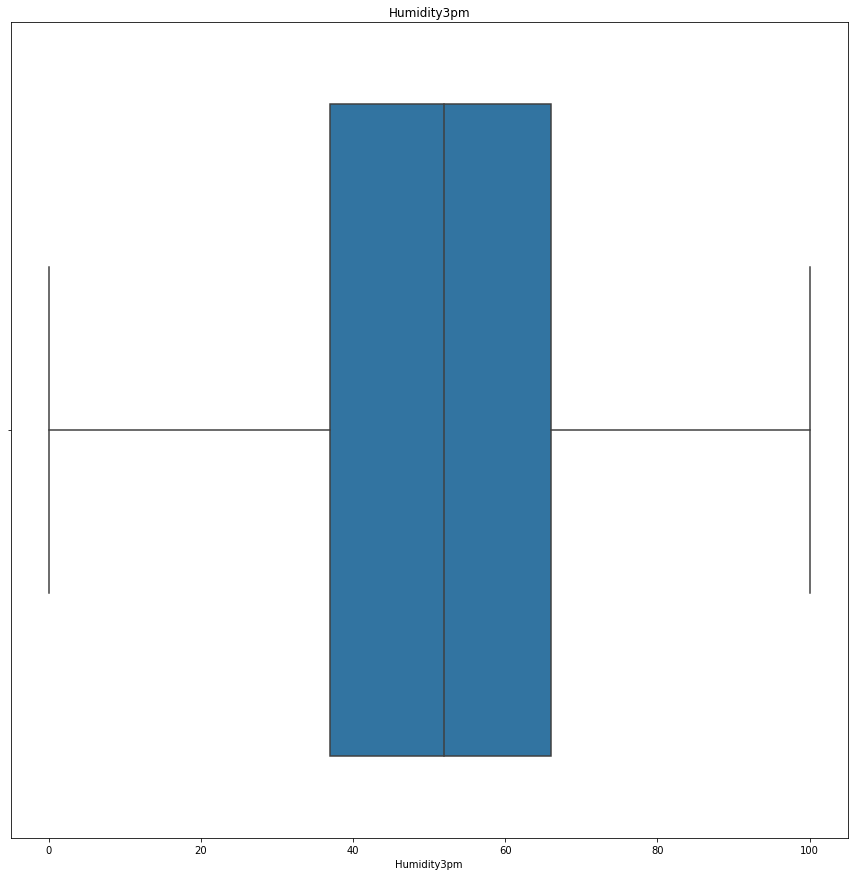

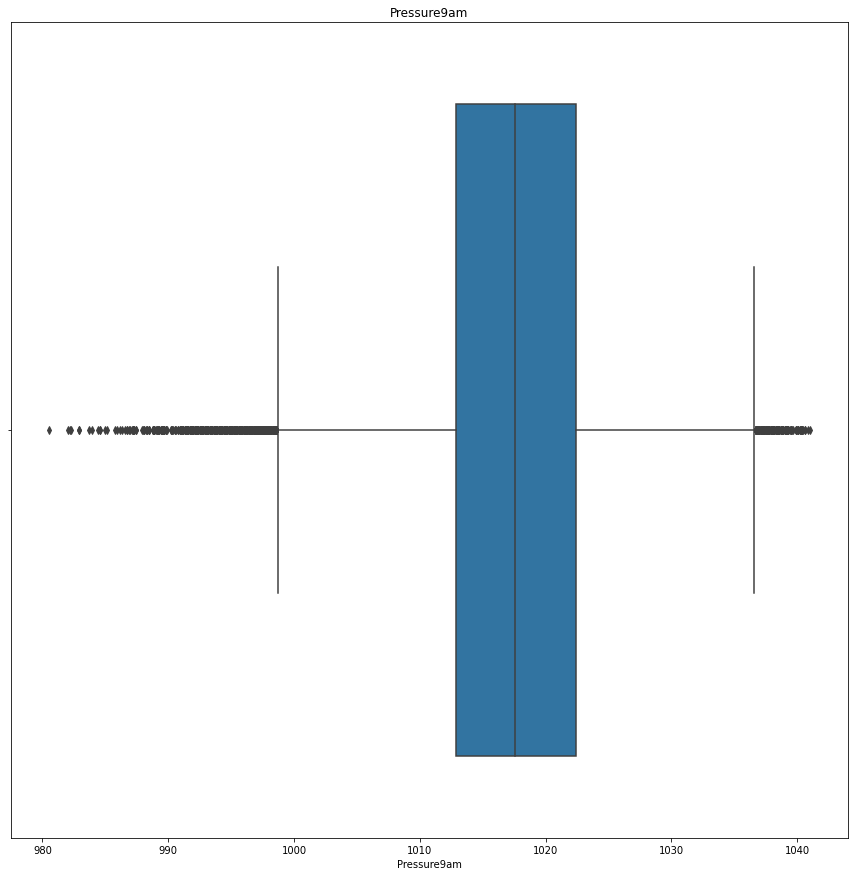

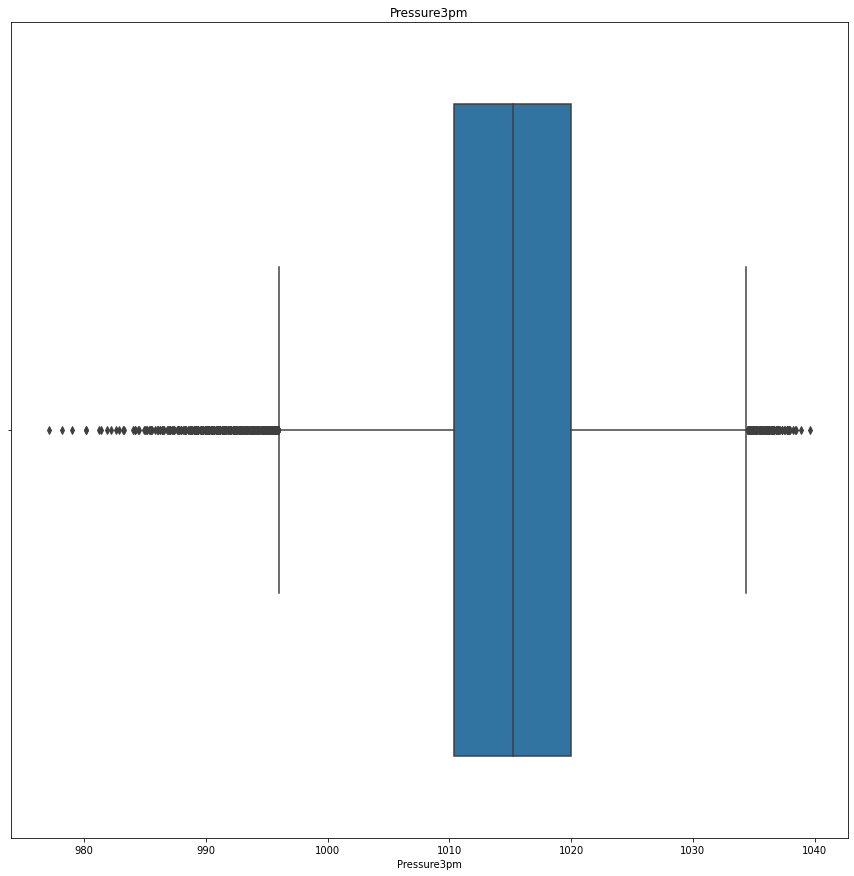

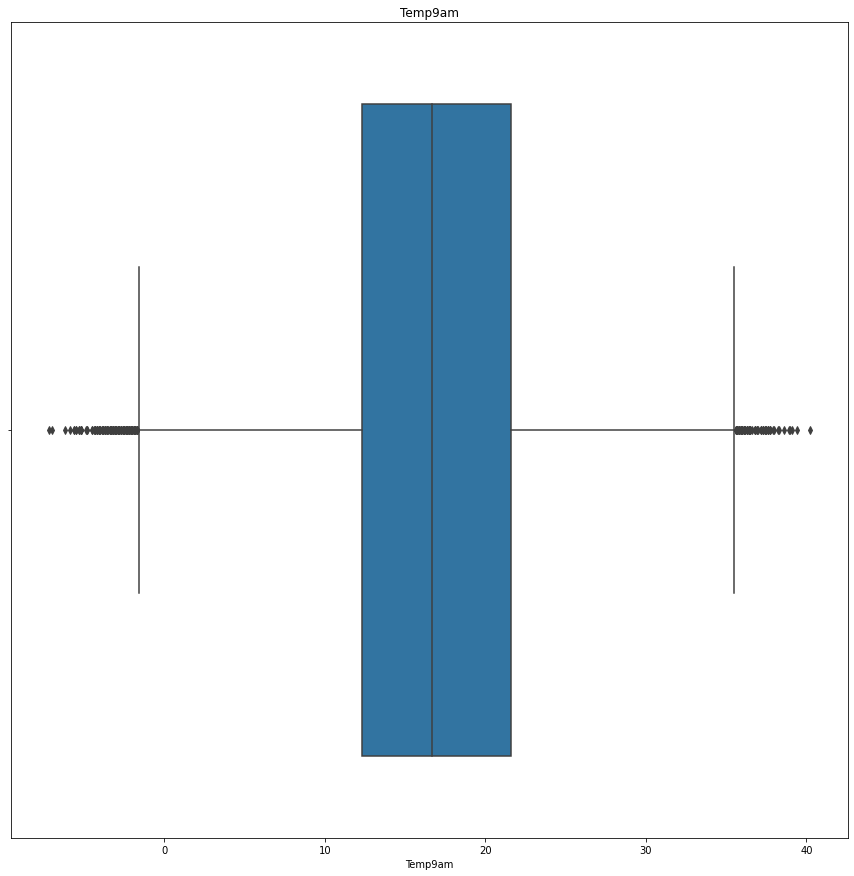

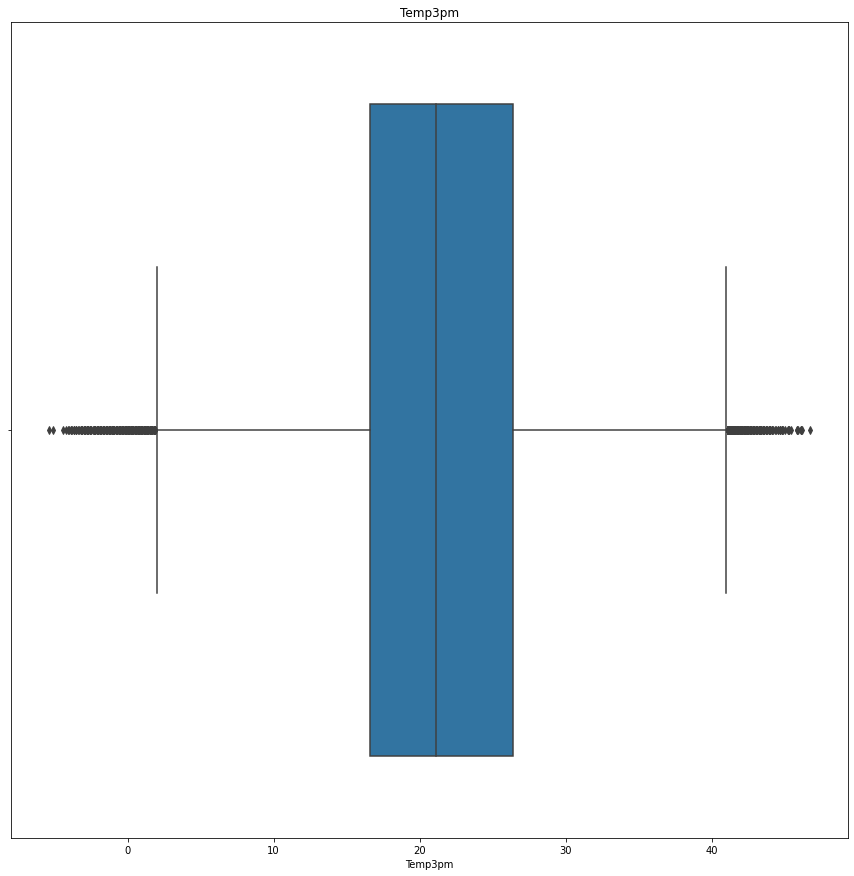

<Figure size 1080x1080 with 0 Axes>

In [11]:
#A for loop is used to plot a boxplot for all the continuous features to see the outliers
for feature in continuous_feature:
    data=df.copy()
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.figure(figsize=(15,15))

In [12]:
for feature in continuous_feature:
    if(df[feature].isnull().sum()*100/len(df))>0:
        df[feature] = df[feature].fillna(df[feature].median())

In [13]:
df.isnull().sum()*100/len(df)

Date             0.000000
Location         0.000000
MinTemp          0.000000
MaxTemp          0.000000
Rainfall         0.000000
Evaporation      0.000000
Sunshine         0.000000
WindGustDir      7.098859
WindGustSpeed    0.000000
WindDir9am       7.263853
WindDir3pm       2.906641
WindSpeed9am     0.000000
WindSpeed3pm     0.000000
Humidity9am      0.000000
Humidity3pm      0.000000
Pressure9am      0.000000
Pressure3pm      0.000000
Cloud9am         0.000000
Cloud3pm         0.000000
Temp9am          0.000000
Temp3pm          0.000000
RainToday        2.241853
RainTomorrow     2.245978
dtype: float64

In [14]:
discrete_feature

['Cloud9am', 'Cloud3pm']

In [15]:
def mode_nan(df,variable):
    mode=df[variable].value_counts().index[0]
    df[variable].fillna(mode,inplace=True)
mode_nan(df,"Cloud9am")
mode_nan(df,"Cloud3pm")

In [16]:
df["RainToday"] = pd.get_dummies(df["RainToday"], drop_first = True)
df["RainTomorrow"] = pd.get_dummies(df["RainTomorrow"], drop_first = True)
df

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0       2008-12-01   Albury     13.4     22.9       0.6          2.4   
1       2008-12-02   Albury      7.4     25.1       0.0          3.6   
2       2008-12-03   Albury     12.9     25.7       0.0          2.6   
3       2008-12-04   Albury      9.2     28.0       0.0         18.4   
4       2008-12-05   Albury     17.5     32.3       1.0          5.4   
...            ...      ...      ...      ...       ...          ...   
145455  2017-06-21    Uluru      2.8     23.4       0.0          1.4   
145456  2017-06-22    Uluru      3.6     25.3       0.0          7.6   
145457  2017-06-23    Uluru      5.4     26.9       0.0          6.8   
145458  2017-06-24    Uluru      7.8     27.0       0.0          2.6   
145459  2017-06-25    Uluru     14.9     22.6       0.0          1.4   

        Sunshine WindGustDir  WindGustSpeed WindDir9am WindDir3pm  \
0            8.3           W           44.0          W        WNW   
1           10.0         WNW           44.0        NNW        WSW   
2            4.4         WSW           46.0          W        WSW   
3            8.9          NE           24.0         SE          E   
4            3.0           W           41.0        ENE         NW   
...          ...         ...            ...        ...        ...   
145455       7.8           E           31.0         SE        ENE   
145456      13.5         NNW           22.0         SE          N   
145457      11.0           N           37.0         SE        WNW   
145458      13.2          SE           28.0        SSE          N   
145459       0.7         NaN           39.0        ESE        ESE   

        WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
0               20.0          24.0         71.0         22.0       1007.7   
1                4.0          22.0         44.0         25.0       1010.6   
2               19.0          26.0         38.0         30.0       1007.6   
3               11.0           9.0         45.0         16.0       1017.6   
4                7.0          20.0         82.0         33.0       1010.8   
...              ...           ...          ...          ...          ...   
145455          13.0          11.0         51.0         24.0       1024.6   
145456          13.0           9.0         56.0         21.0       1023.5   
145457           9.0           9.0         53.0         24.0       1021.0   
145458          13.0           7.0         51.0         24.0       1019.4   
145459          17.0          17.0         62.0         36.0       1020.2   

        Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0            1007.1       8.0       0.0     16.9     21.8          0   
1            1007.8       7.0       1.0     17.2     24.3          0   
2            1008.7       8.0       2.0     21.0     23.2          0   
3            1012.8       0.0       5.0     18.1     26.5          0   
4            1006.0       7.0       8.0     17.8     29.7          0   
...             ...       ...       ...      ...      ...        ...   
145455       1020.3       1.0       1.0     10.1     22.4          0   
145456       1019.1       8.0       5.0     10.9     24.5          0   
145457       1016.8       8.0       1.0     12.5     26.1          0   
145458       1016.5       3.0       2.0     15.1     26.0          0   
145459       1017.9       8.0       8.0     15.0     20.9          0   

        RainTomorrow  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
145455             0  
145456             0  
145457             0  
145458             0  
145459             0  

[145460 rows x 23 columns]

In [17]:
for feature in categorical_feature:
    print(feature, (df.groupby([feature])["RainTomorrow"].mean().sort_values(ascending = False)).index)

Date Index(['2007-11-01', '2008-01-19', '2007-12-07', '2007-12-15', '2007-12-16',
       '2007-12-19', '2007-12-20', '2007-12-21', '2007-12-22', '2007-12-24',
       ...
       '2008-05-02', '2008-05-01', '2008-04-30', '2008-04-29', '2008-04-28',
       '2008-04-26', '2008-04-25', '2016-11-26', '2012-04-07', '2008-08-17'],
      dtype='object', name='Date', length=3436)
Location Index(['Portland', 'Walpole', 'Cairns', 'Dartmoor', 'NorfolkIsland',
       'MountGambier', 'Albany', 'Witchcliffe', 'CoffsHarbour', 'MountGinini',
       'NorahHead', 'Darwin', 'Sydney', 'SydneyAirport', 'Ballarat',
       'GoldCoast', 'Watsonia', 'Newcastle', 'Hobart', 'Wollongong',
       'Williamtown', 'Launceston', 'Brisbane', 'MelbourneAirport', 'Adelaide',
       'Sale', 'Albury', 'Perth', 'Melbourne', 'Nuriootpa', 'Penrith',
       'BadgerysCreek', 'PerthAirport', 'Tuggeranong', 'Richmond', 'Bendigo',
       'Canberra', 'WaggaWagga', 'Townsville', 'Katherine', 'PearceRAAF',
       'SalmonGums', 'Nhil', 

In [18]:
windgustdir = {'NNW':0, 'NW':1, 'WNW':2, 'N':3, 'W':4, 'WSW':5, 'NNE':6, 'S':7, 'SSW':8, 'SW':9, 'SSE':10,
       'NE':11, 'SE':12, 'ESE':13, 'ENE':14, 'E':15}
winddir9am = {'NNW':0, 'N':1, 'NW':2, 'NNE':3, 'WNW':4, 'W':5, 'WSW':6, 'SW':7, 'SSW':8, 'NE':9, 'S':10,
       'SSE':11, 'ENE':12, 'SE':13, 'ESE':14, 'E':15}
winddir3pm = {'NW':0, 'NNW':1, 'N':2, 'WNW':3, 'W':4, 'NNE':5, 'WSW':6, 'SSW':7, 'S':8, 'SW':9, 'SE':10,
       'NE':11, 'SSE':12, 'ENE':13, 'E':14, 'ESE':15}
df["WindGustDir"] = df["WindGustDir"].map(windgustdir)
df["WindDir9am"] = df["WindDir9am"].map(winddir9am)
df["WindDir3pm"] = df["WindDir3pm"].map(winddir3pm)

In [19]:
df["WindGustDir"] = df["WindGustDir"].fillna(df["WindGustDir"].value_counts().index[0])
df["WindDir9am"] = df["WindDir9am"].fillna(df["WindDir9am"].value_counts().index[0])
df["WindDir3pm"] = df["WindDir3pm"].fillna(df["WindDir3pm"].value_counts().index[0])

In [20]:
df.isnull().sum()*100/len(df)

Date             0.0
Location         0.0
MinTemp          0.0
MaxTemp          0.0
Rainfall         0.0
Evaporation      0.0
Sunshine         0.0
WindGustDir      0.0
WindGustSpeed    0.0
WindDir9am       0.0
WindDir3pm       0.0
WindSpeed9am     0.0
WindSpeed3pm     0.0
Humidity9am      0.0
Humidity3pm      0.0
Pressure9am      0.0
Pressure3pm      0.0
Cloud9am         0.0
Cloud3pm         0.0
Temp9am          0.0
Temp3pm          0.0
RainToday        0.0
RainTomorrow     0.0
dtype: float64

In [21]:
encoder = preprocessing.LabelEncoder() 
df['Location']= encoder.fit_transform(df['Location']) 

In [22]:
df["Date"] = pd.to_datetime(df["Date"], format = "%Y-%m-%dT", errors = "coerce")

In [23]:
df["Date_year"] = df["Date"].dt.year
df["Date_month"] = df["Date"].dt.month
df["Date_day"] = df["Date"].dt.day

In [24]:
df

Date  Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0      2008-12-01         2     13.4     22.9       0.6          2.4   
1      2008-12-02         2      7.4     25.1       0.0          3.6   
2      2008-12-03         2     12.9     25.7       0.0          2.6   
3      2008-12-04         2      9.2     28.0       0.0         18.4   
4      2008-12-05         2     17.5     32.3       1.0          5.4   
...           ...       ...      ...      ...       ...          ...   
145455 2017-06-21        41      2.8     23.4       0.0          1.4   
145456 2017-06-22        41      3.6     25.3       0.0          7.6   
145457 2017-06-23        41      5.4     26.9       0.0          6.8   
145458 2017-06-24        41      7.8     27.0       0.0          2.6   
145459 2017-06-25        41     14.9     22.6       0.0          1.4   

        Sunshine  WindGustDir  WindGustSpeed  WindDir9am  WindDir3pm  \
0            8.3          4.0           44.0         5.0         3.0   
1           10.0          2.0           44.0         0.0         6.0   
2            4.4          5.0           46.0         5.0         6.0   
3            8.9         11.0           24.0        13.0        14.0   
4            3.0          4.0           41.0        12.0         0.0   
...          ...          ...            ...         ...         ...   
145455       7.8         15.0           31.0        13.0        13.0   
145456      13.5          0.0           22.0        13.0         2.0   
145457      11.0          3.0           37.0        13.0         3.0   
145458      13.2         12.0           28.0        11.0         2.0   
145459       0.7          4.0           39.0        14.0        15.0   

        WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
0               20.0          24.0         71.0         22.0       1007.7   
1                4.0          22.0         44.0         25.0       1010.6   
2               19.0          26.0         38.0         30.0       1007.6   
3               11.0           9.0         45.0         16.0       1017.6   
4                7.0          20.0         82.0         33.0       1010.8   
...              ...           ...          ...          ...          ...   
145455          13.0          11.0         51.0         24.0       1024.6   
145456          13.0           9.0         56.0         21.0       1023.5   
145457           9.0           9.0         53.0         24.0       1021.0   
145458          13.0           7.0         51.0         24.0       1019.4   
145459          17.0          17.0         62.0         36.0       1020.2   

        Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0            1007.1       8.0       0.0     16.9     21.8          0   
1            1007.8       7.0       1.0     17.2     24.3          0   
2            1008.7       8.0       2.0     21.0     23.2          0   
3            1012.8       0.0       5.0     18.1     26.5          0   
4            1006.0       7.0       8.0     17.8     29.7          0   
...             ...       ...       ...      ...      ...        ...   
145455       1020.3       1.0       1.0     10.1     22.4          0   
145456       1019.1       8.0       5.0     10.9     24.5          0   
145457       1016.8       8.0       1.0     12.5     26.1          0   
145458       1016.5       3.0       2.0     15.1     26.0          0   
145459       1017.9       8.0       8.0     15.0     20.9          0   

        RainTomorrow  Date_year  Date_month  Date_day  
0                  0       2008          12         1  
1                  0       2008          12         2  
2                  0       2008          12         3  
3                  0       2008          12         4  
4                  0       2008          12         5  
...              ...        ...         ...       ...  
145455             0       2017           6        21  
145456             0       2017           6  

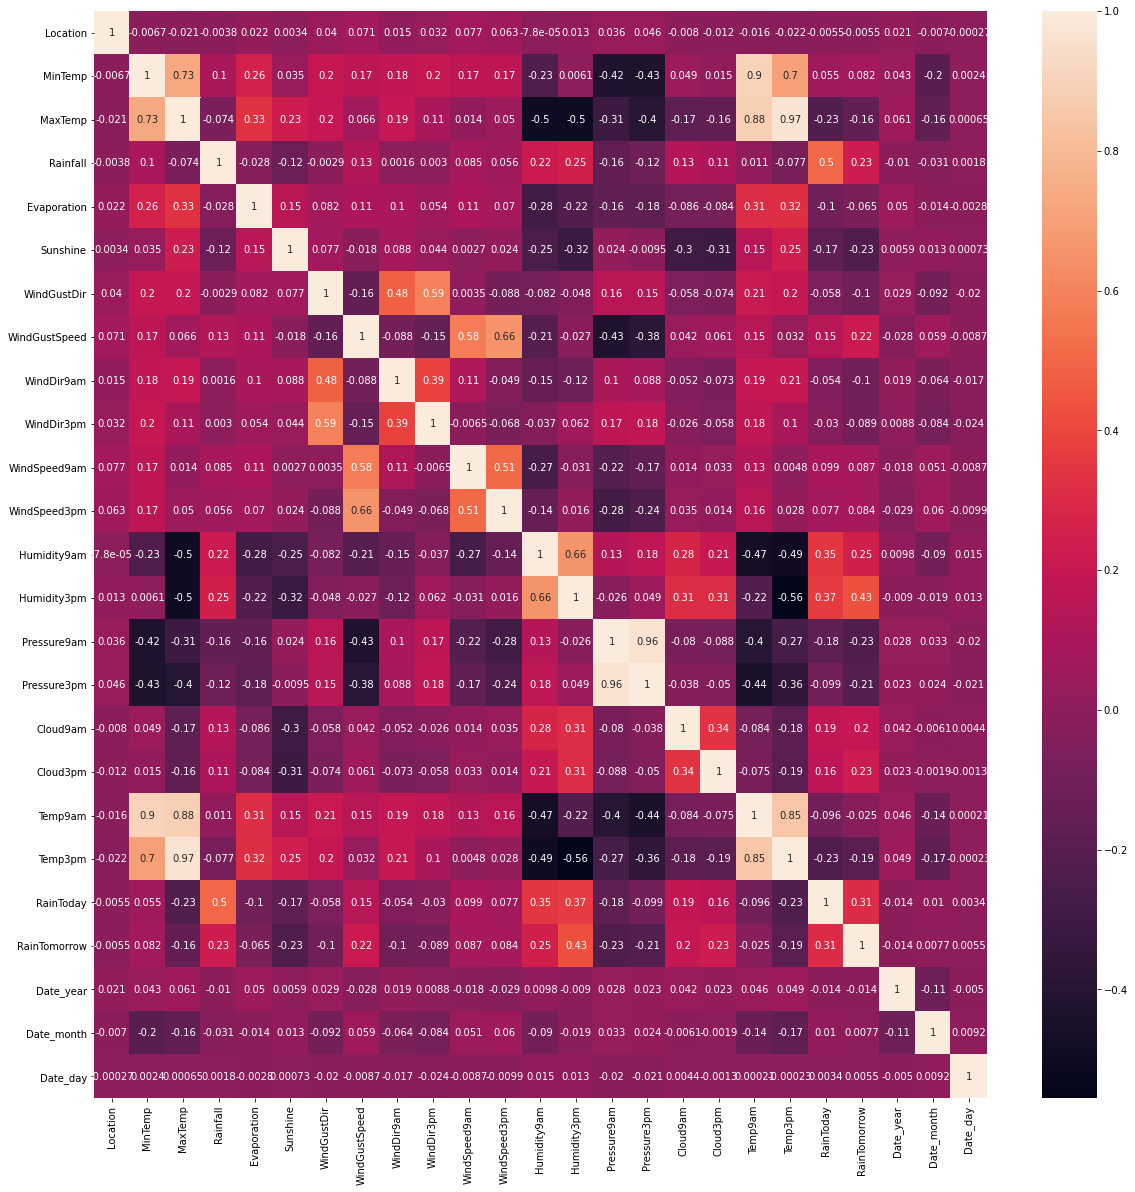

In [25]:
corrmat = df.corr()
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(corrmat,annot=True)

c:\users\admin\anaconda3\envs\rainprediction\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='RainTomorrow', ylabel='count'>

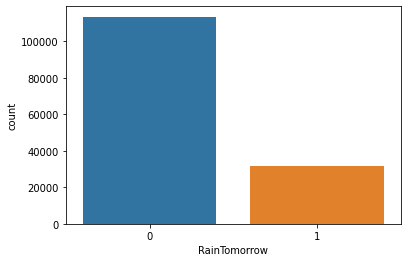

In [26]:
sns.countplot(df["RainTomorrow"])

In [27]:
df

Date  Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0      2008-12-01         2     13.4     22.9       0.6          2.4   
1      2008-12-02         2      7.4     25.1       0.0          3.6   
2      2008-12-03         2     12.9     25.7       0.0          2.6   
3      2008-12-04         2      9.2     28.0       0.0         18.4   
4      2008-12-05         2     17.5     32.3       1.0          5.4   
...           ...       ...      ...      ...       ...          ...   
145455 2017-06-21        41      2.8     23.4       0.0          1.4   
145456 2017-06-22        41      3.6     25.3       0.0          7.6   
145457 2017-06-23        41      5.4     26.9       0.0          6.8   
145458 2017-06-24        41      7.8     27.0       0.0          2.6   
145459 2017-06-25        41     14.9     22.6       0.0          1.4   

        Sunshine  WindGustDir  WindGustSpeed  WindDir9am  WindDir3pm  \
0            8.3          4.0           44.0         5.0         3.0   
1           10.0          2.0           44.0         0.0         6.0   
2            4.4          5.0           46.0         5.0         6.0   
3            8.9         11.0           24.0        13.0        14.0   
4            3.0          4.0           41.0        12.0         0.0   
...          ...          ...            ...         ...         ...   
145455       7.8         15.0           31.0        13.0        13.0   
145456      13.5          0.0           22.0        13.0         2.0   
145457      11.0          3.0           37.0        13.0         3.0   
145458      13.2         12.0           28.0        11.0         2.0   
145459       0.7          4.0           39.0        14.0        15.0   

        WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
0               20.0          24.0         71.0         22.0       1007.7   
1                4.0          22.0         44.0         25.0       1010.6   
2               19.0          26.0         38.0         30.0       1007.6   
3               11.0           9.0         45.0         16.0       1017.6   
4                7.0          20.0         82.0         33.0       1010.8   
...              ...           ...          ...          ...          ...   
145455          13.0          11.0         51.0         24.0       1024.6   
145456          13.0           9.0         56.0         21.0       1023.5   
145457           9.0           9.0         53.0         24.0       1021.0   
145458          13.0           7.0         51.0         24.0       1019.4   
145459          17.0          17.0         62.0         36.0       1020.2   

        Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0            1007.1       8.0       0.0     16.9     21.8          0   
1            1007.8       7.0       1.0     17.2     24.3          0   
2            1008.7       8.0       2.0     21.0     23.2          0   
3            1012.8       0.0       5.0     18.1     26.5          0   
4            1006.0       7.0       8.0     17.8     29.7          0   
...             ...       ...       ...      ...      ...        ...   
145455       1020.3       1.0       1.0     10.1     22.4          0   
145456       1019.1       8.0       5.0     10.9     24.5          0   
145457       1016.8       8.0       1.0     12.5     26.1          0   
145458       1016.5       3.0       2.0     15.1     26.0          0   
145459       1017.9       8.0       8.0     15.0     20.9          0   

        RainTomorrow  Date_year  Date_month  Date_day  
0                  0       2008          12         1  
1                  0       2008          12         2  
2                  0       2008          12         3  
3                  0       2008          12         4  
4                  0       2008          12         5  
...              ...        ...         ...       ...  
145455             0       2017           6        21  
145456             0       2017           6  

c:\users\admin\anaconda3\envs\rainprediction\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\admin\anaconda3\envs\rainprediction\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\admin\anaconda3\envs\rainprediction\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterp

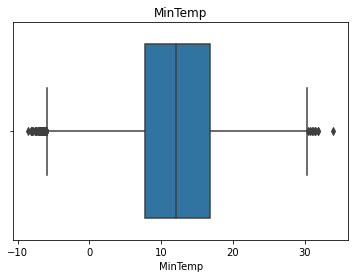

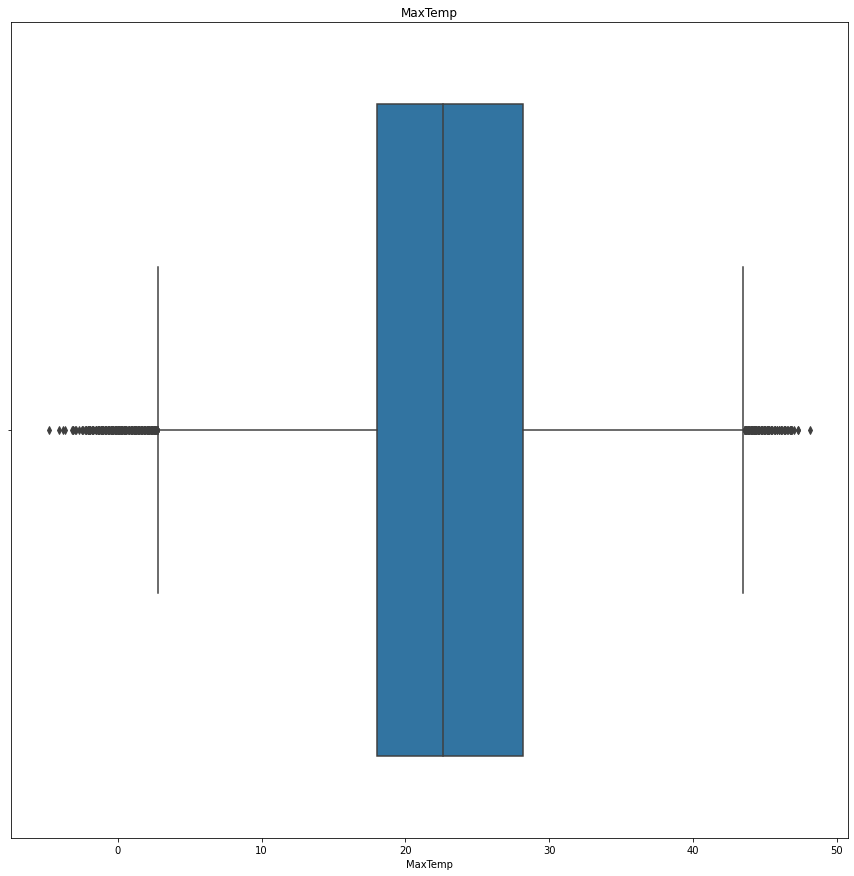

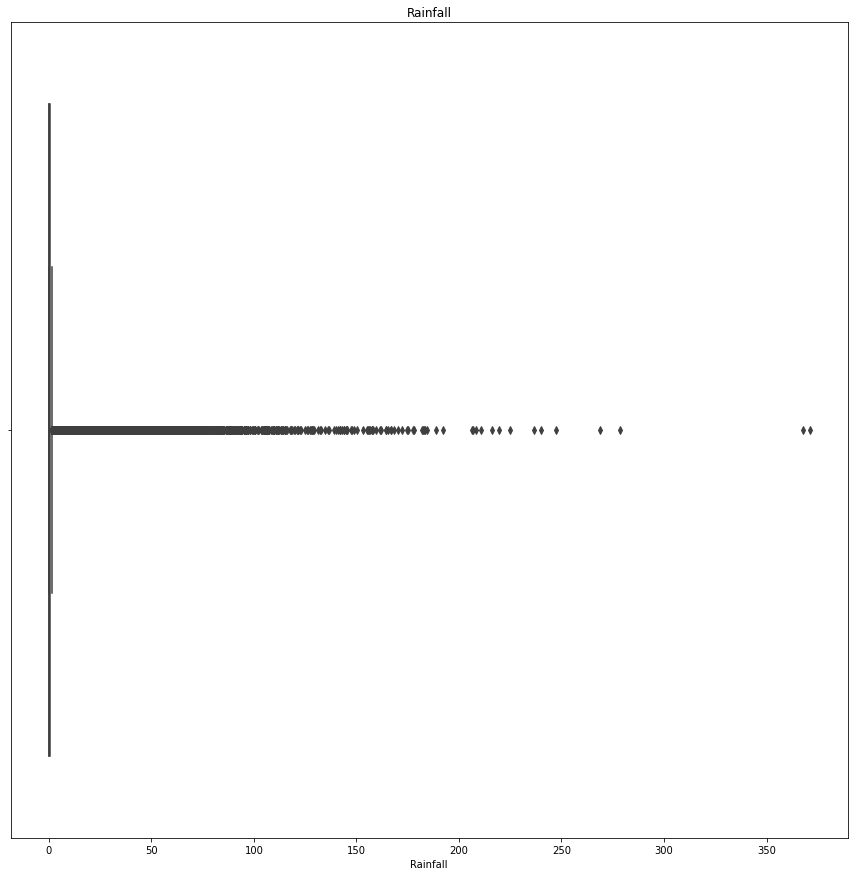

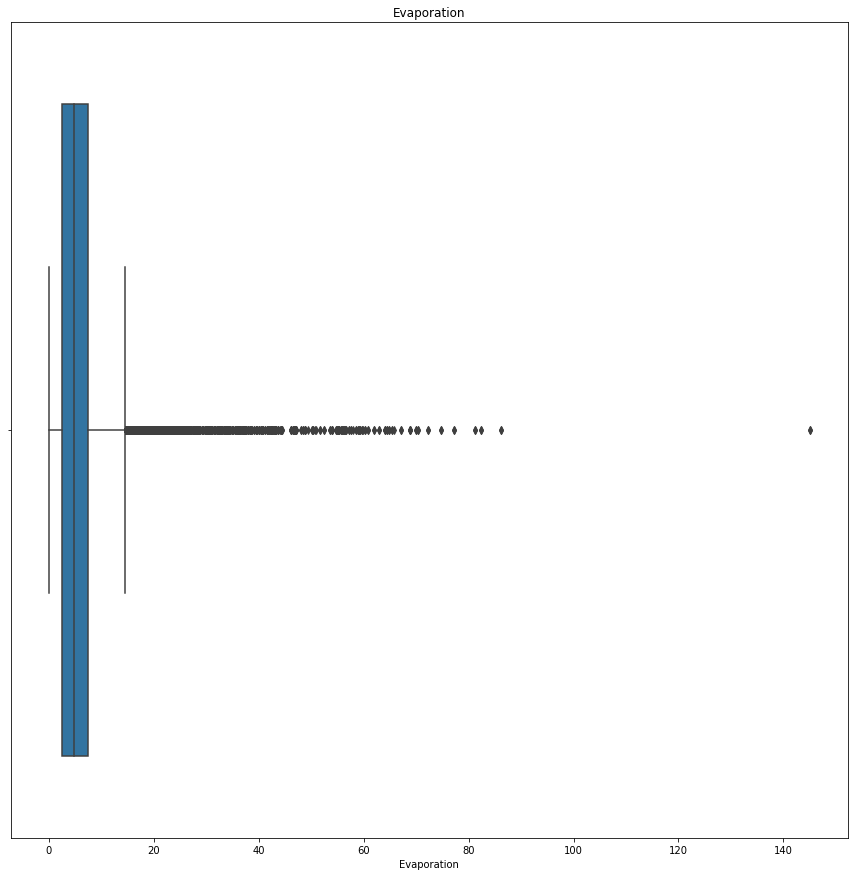

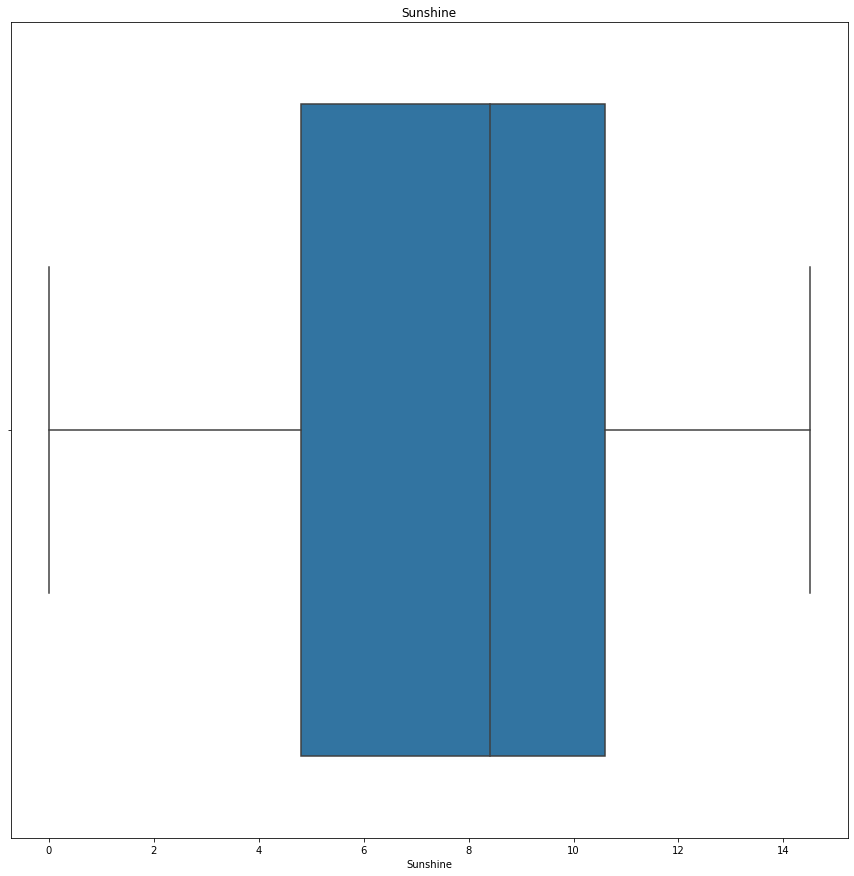

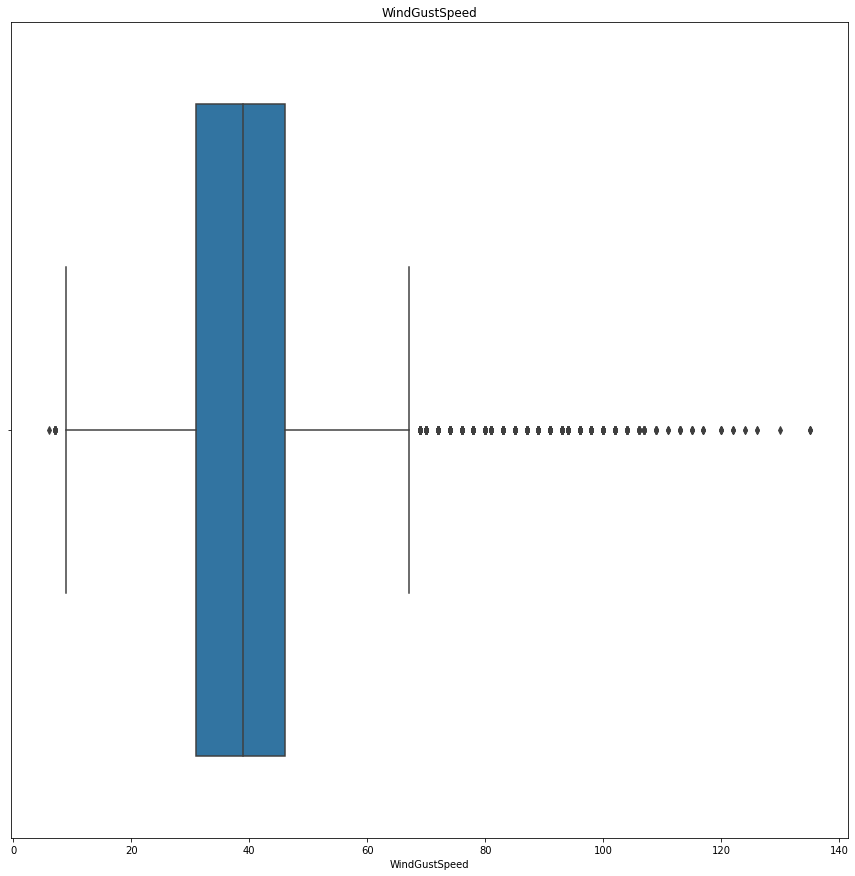

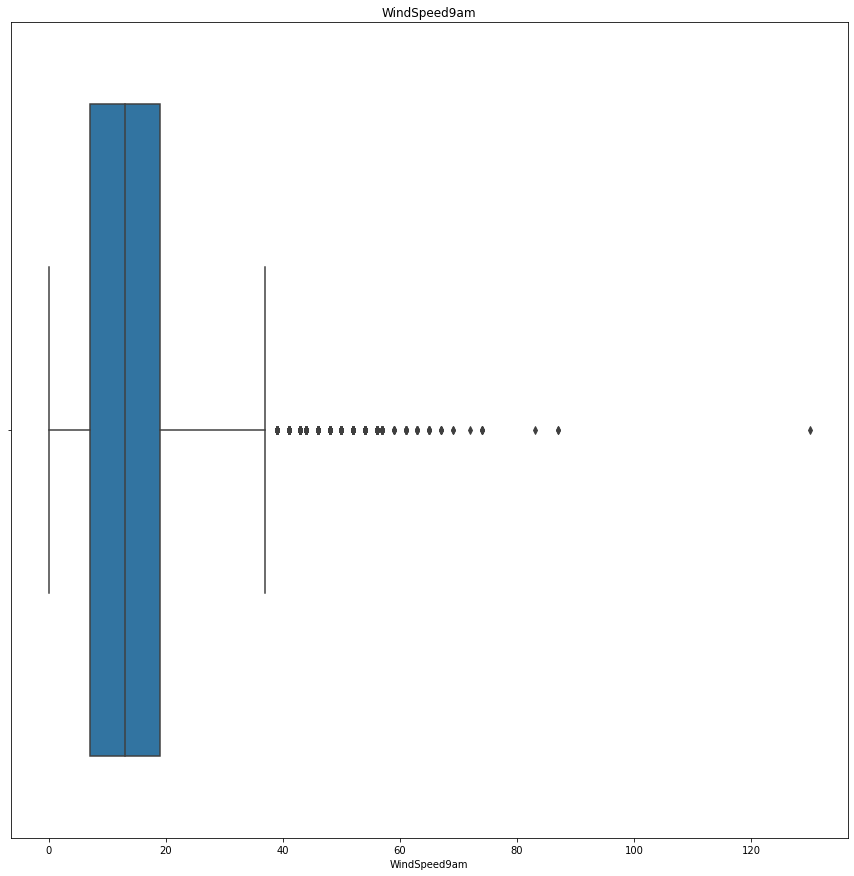

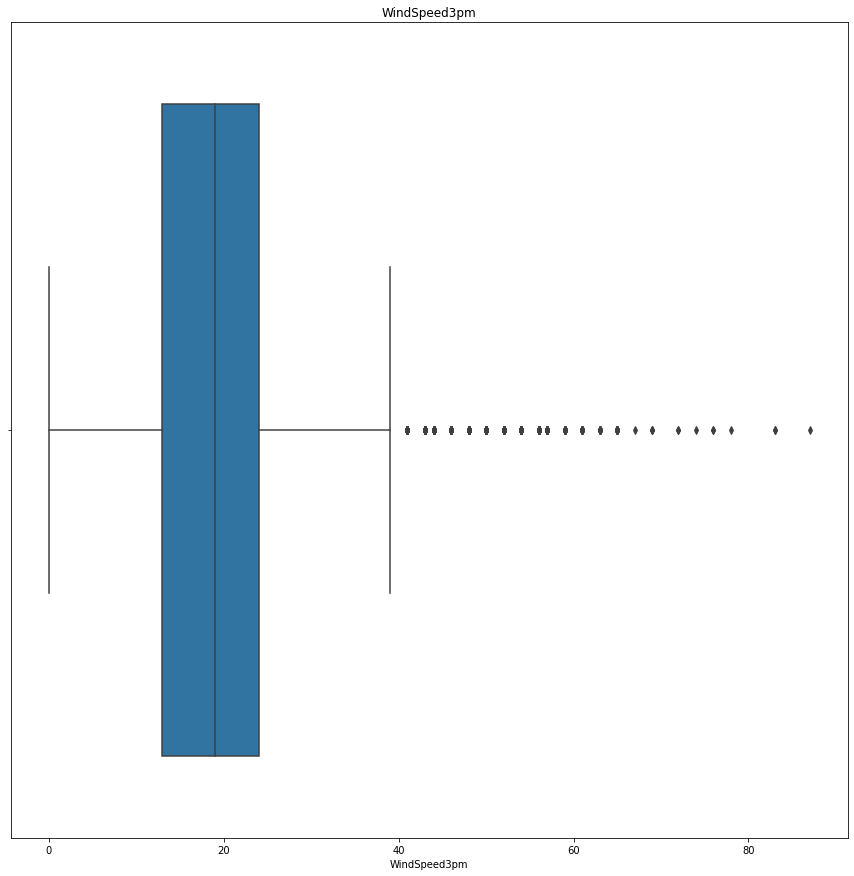

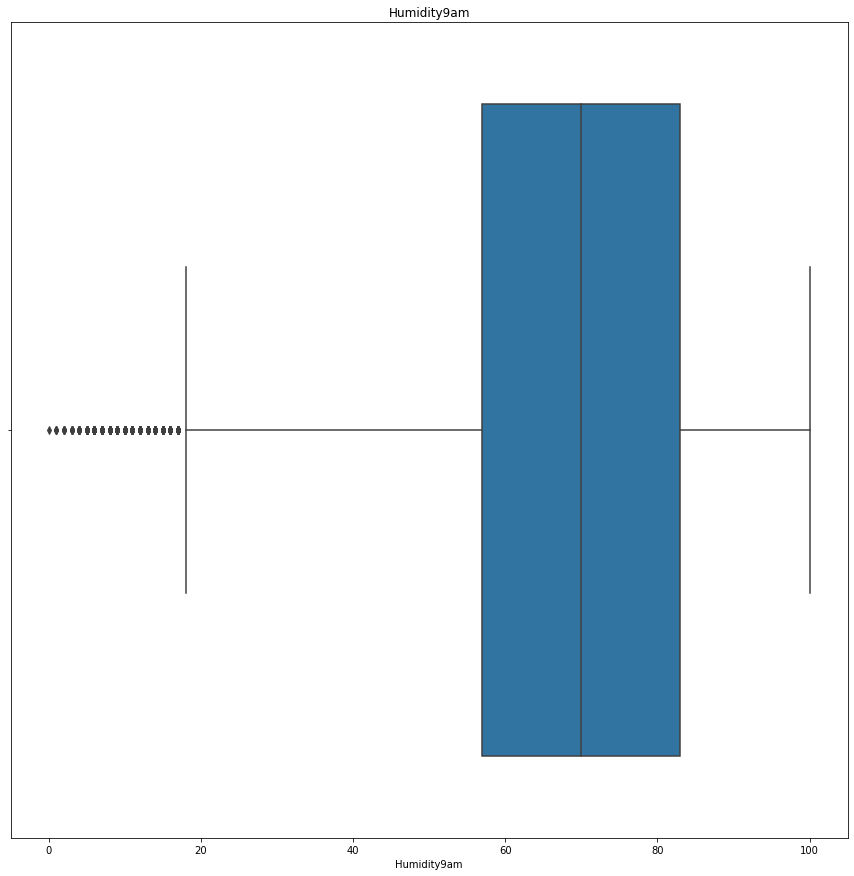

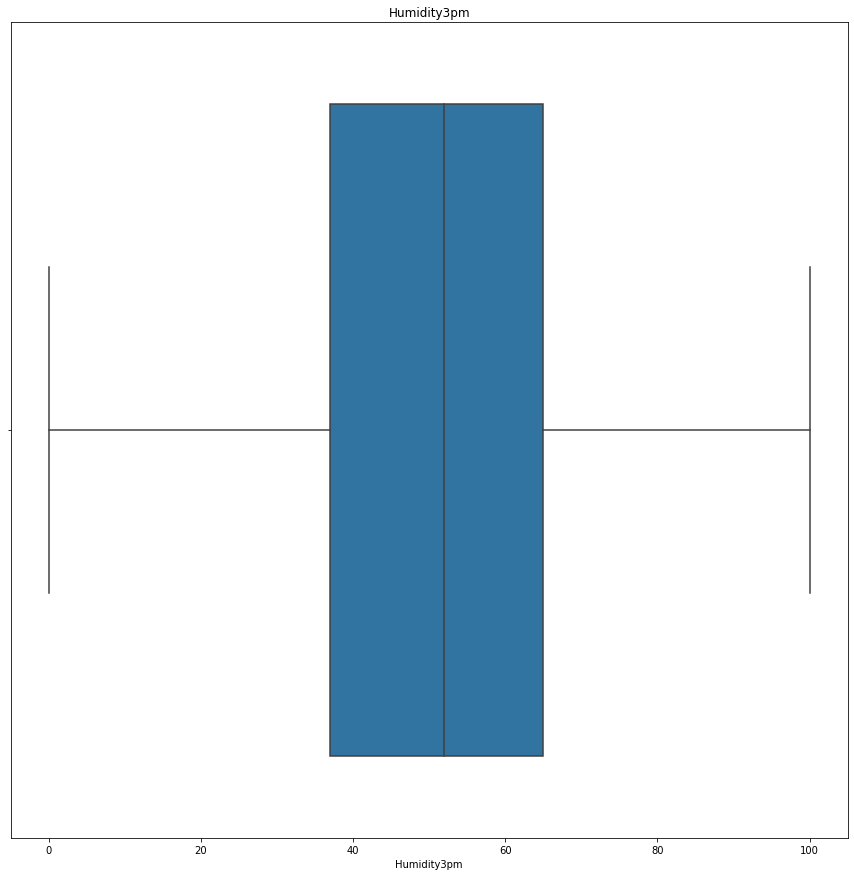

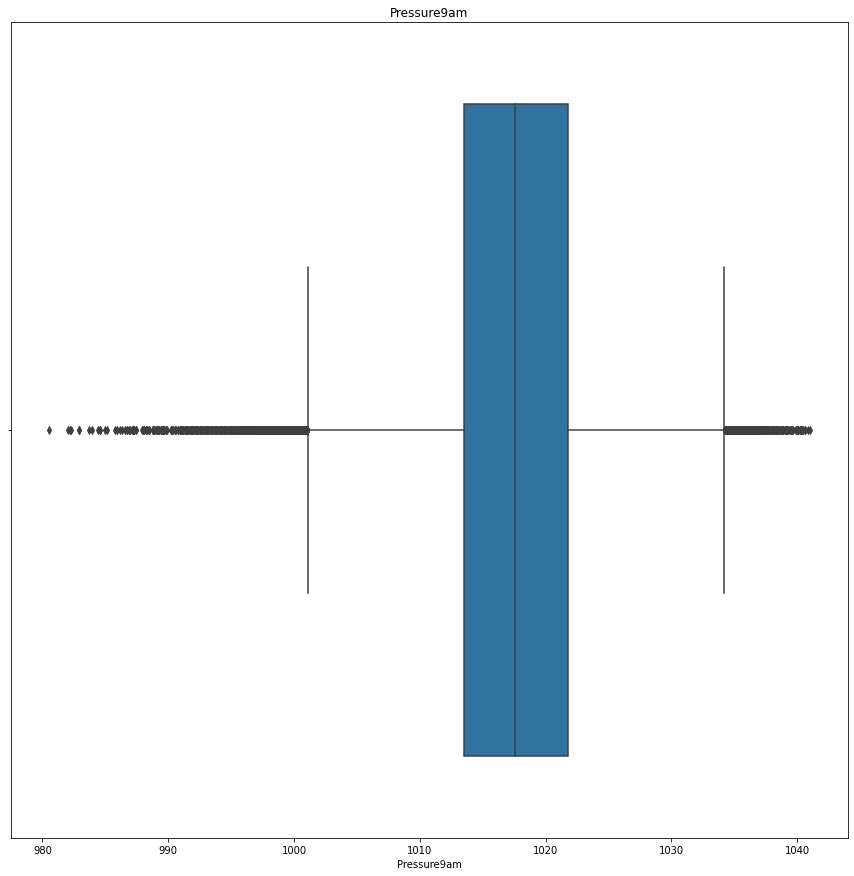

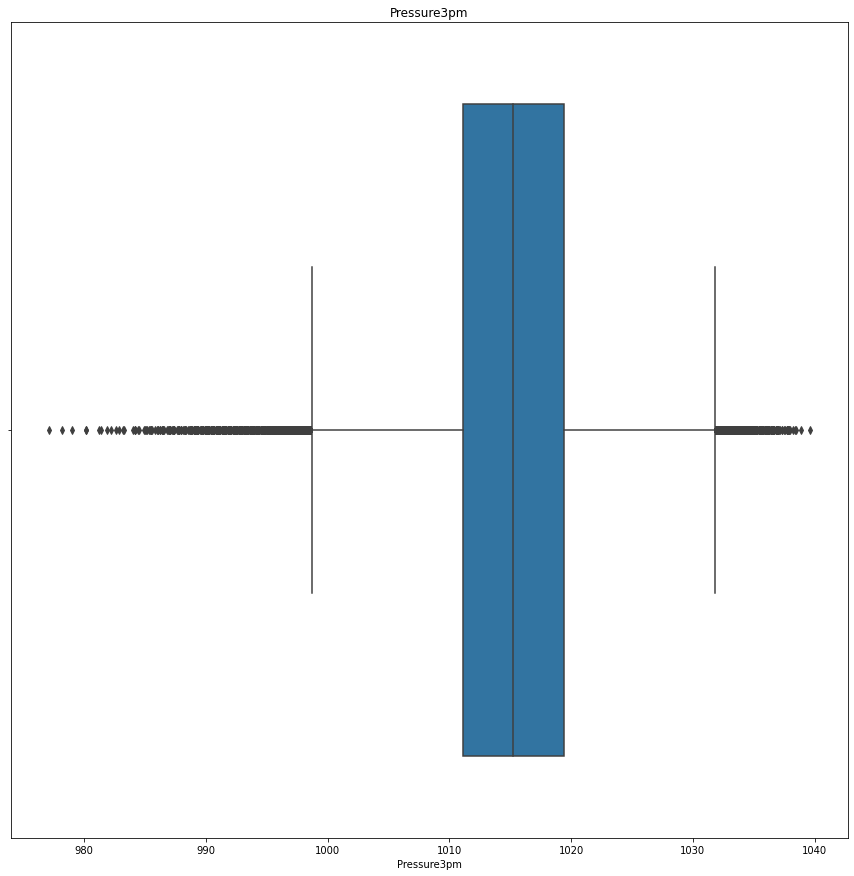

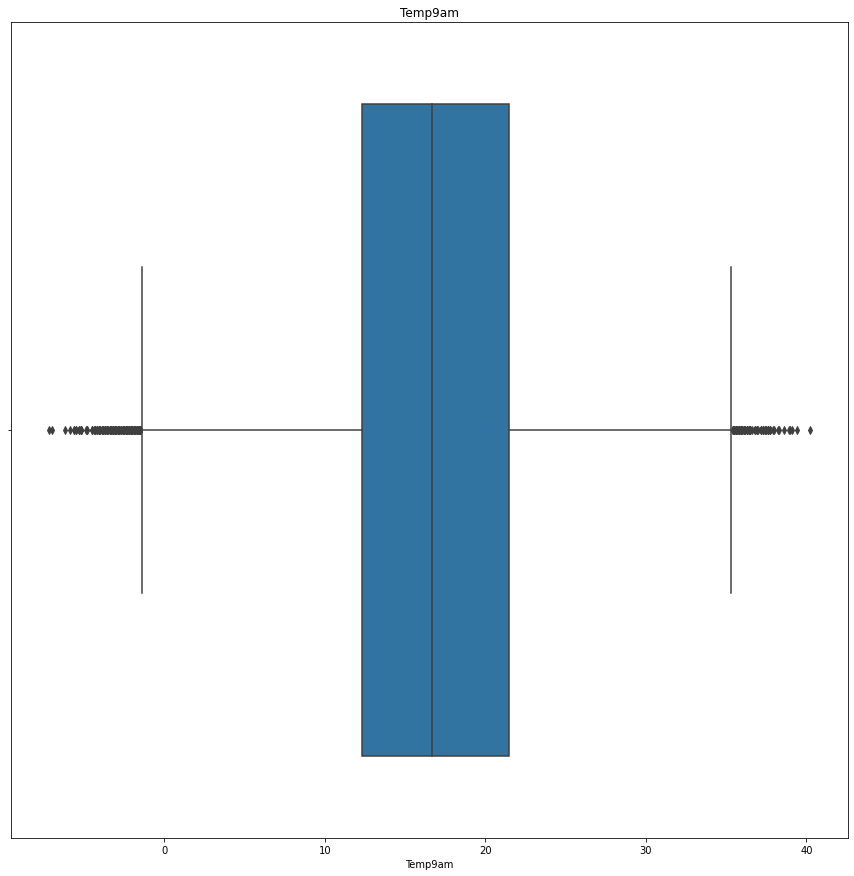

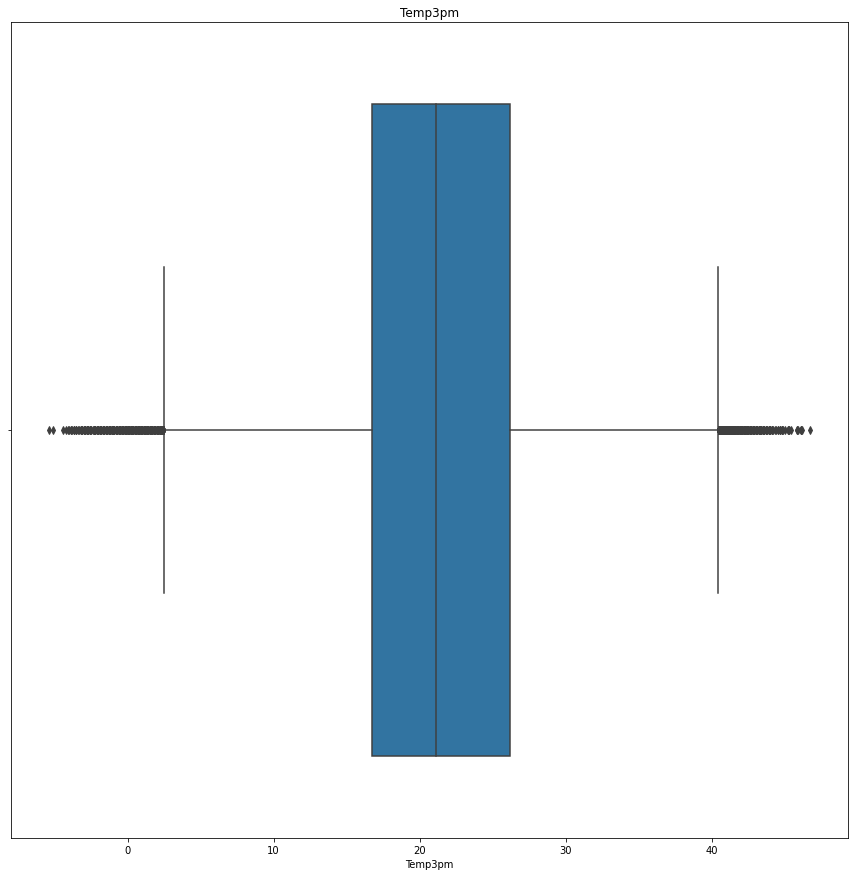

<Figure size 1080x1080 with 0 Axes>

In [28]:
for feature in continuous_feature:
    data=df.copy()
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.figure(figsize=(15,15))

In [29]:
def qq_plots(df, variable):
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()

MinTemp


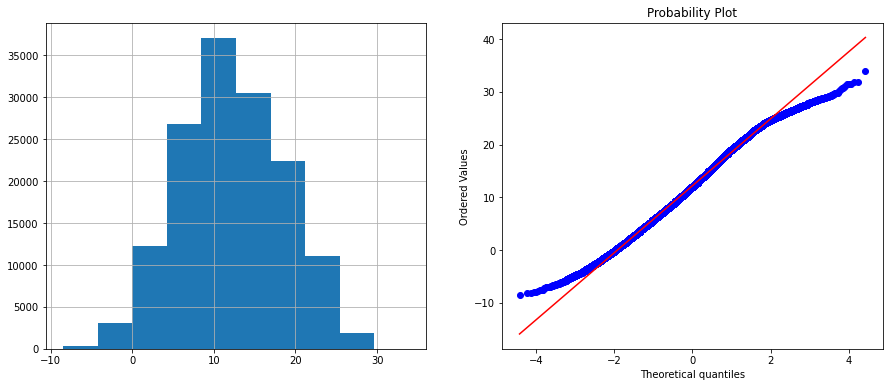

MaxTemp


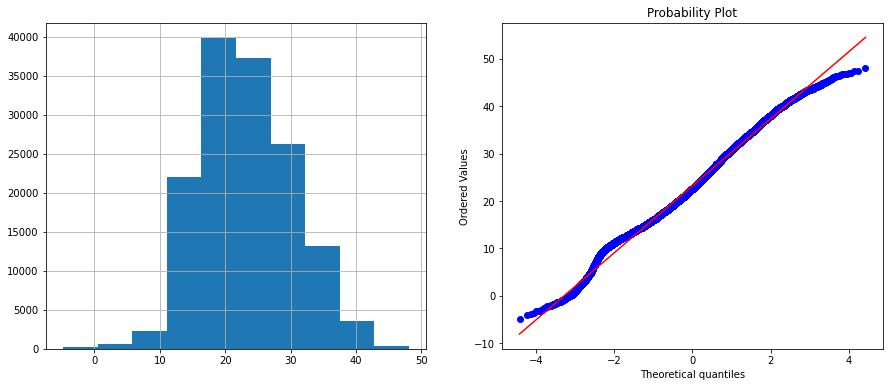

Rainfall


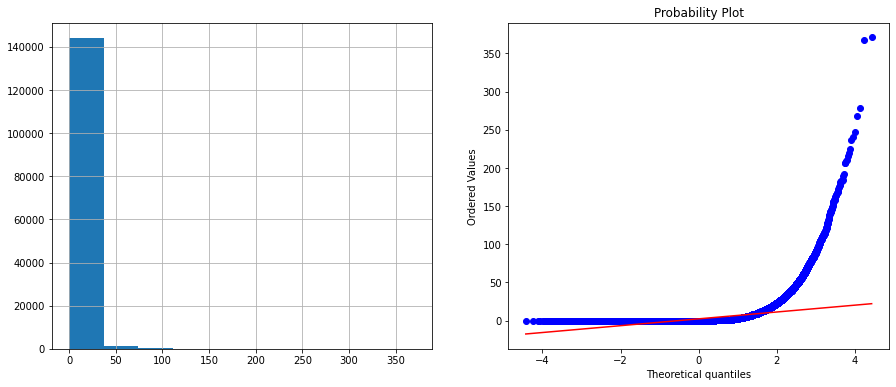

Evaporation


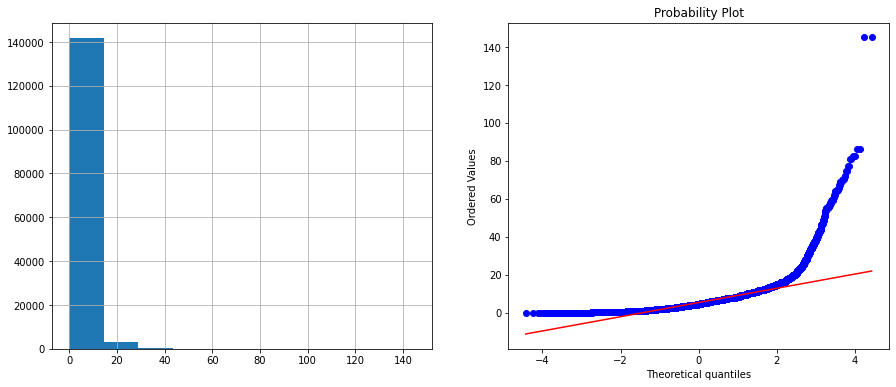

Sunshine


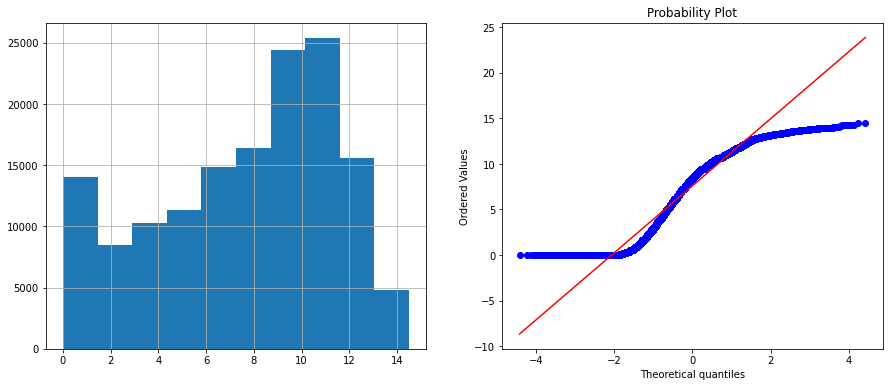

WindGustSpeed


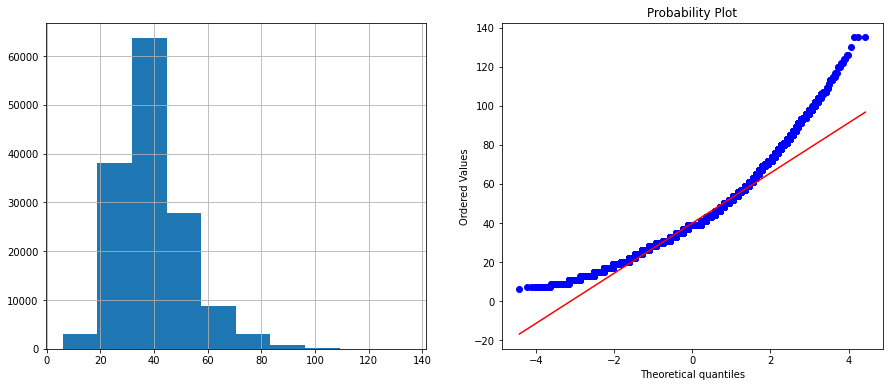

WindSpeed9am


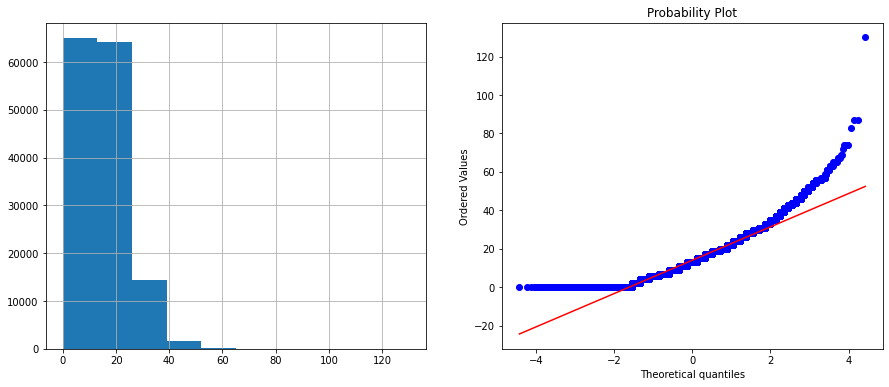

WindSpeed3pm


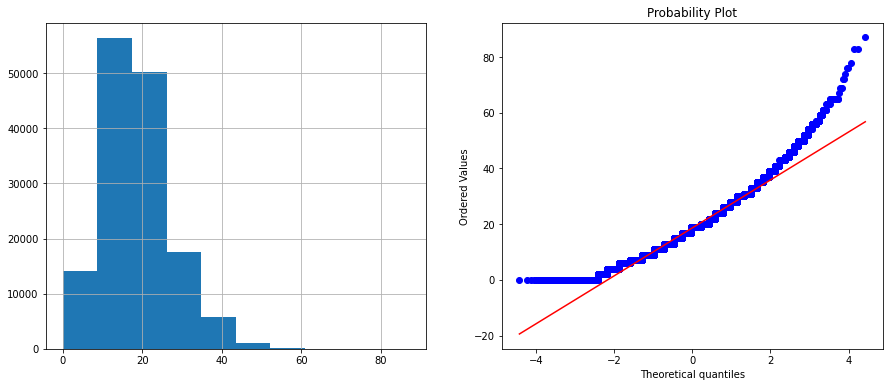

Humidity9am


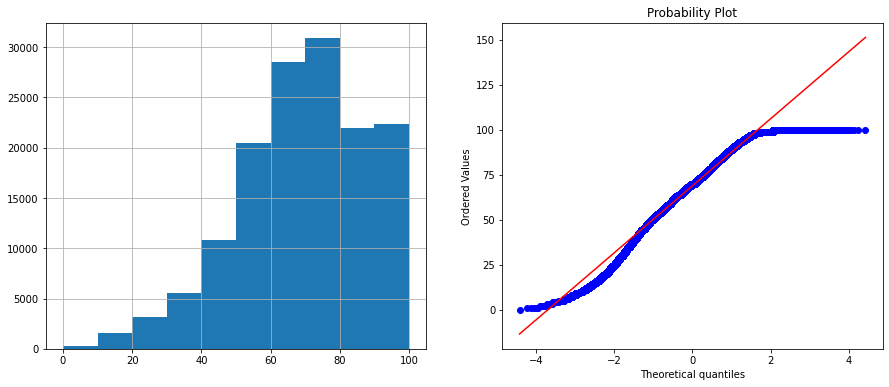

Humidity3pm


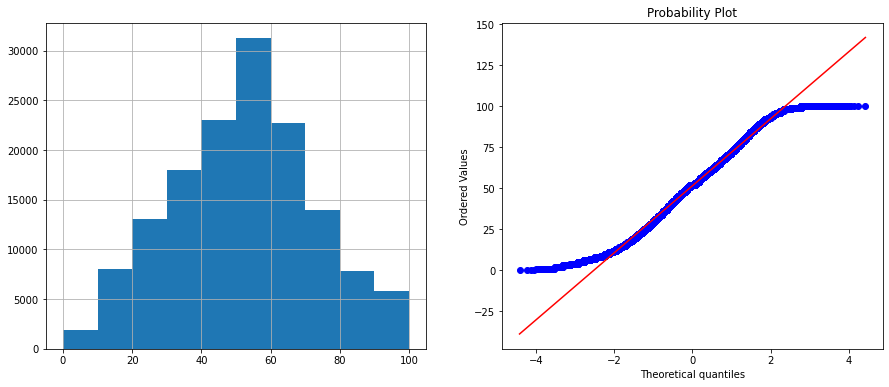

Pressure9am


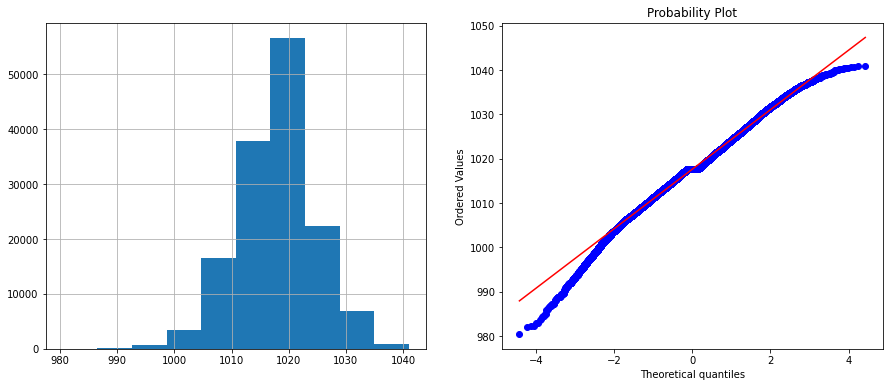

Pressure3pm


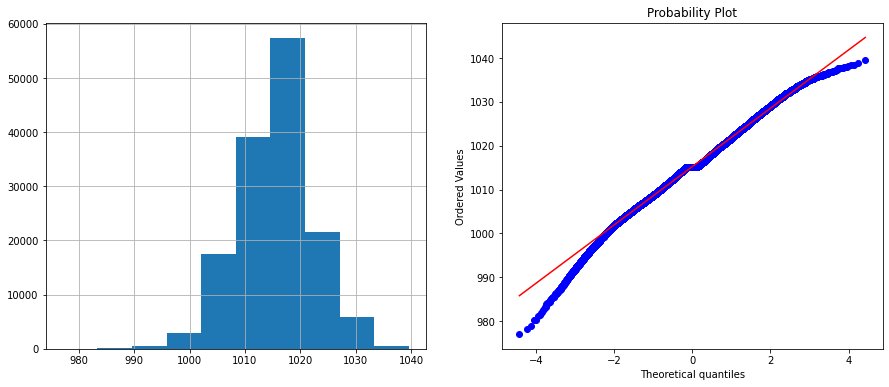

Temp9am


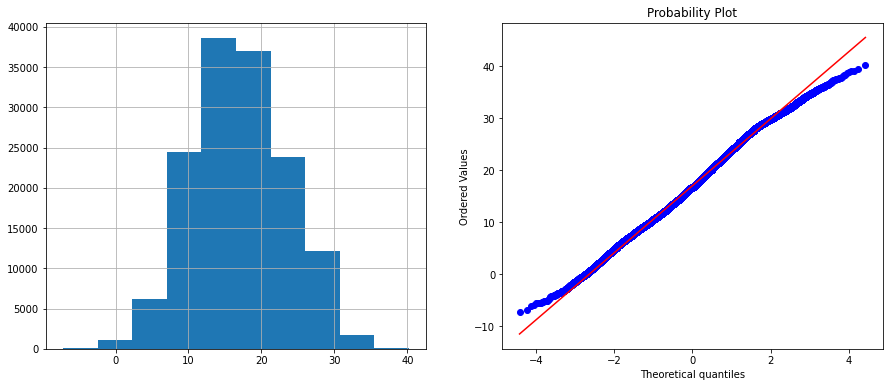

Temp3pm


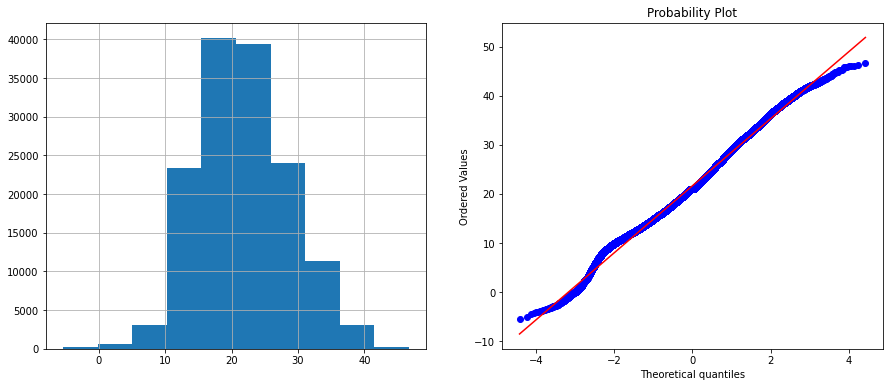

In [30]:
for feature in continuous_feature:
    print(feature)
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[feature].hist()
    plt.subplot(1, 2, 2)
    stats.probplot(df[feature], dist="norm", plot=plt)
    plt.show()

In [32]:
X = df.drop(["RainTomorrow", "Date"], axis=1)
Y = df["RainTomorrow"]

In [33]:
# scaler = RobustScaler()
# X_scaled = scaler.fit_transform(X)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size =0.2, stratify = Y, random_state = 0)

In [35]:
y_train

43447     0
140904    0
54615     0
109793    0
74462     0
         ..
106567    0
52791     1
56339     0
82299     1
115175    0
Name: RainTomorrow, Length: 116368, dtype: uint8

In [36]:
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info

array([0.01180042, 0.00642265, 0.01445269, 0.05174974, 0.00411014,
       0.02865665, 0.00675194, 0.02536683, 0.00625002, 0.00760143,
       0.0049772 , 0.00467683, 0.03705962, 0.10933111, 0.02788731,
       0.02537514, 0.02297441, 0.03294895, 0.00208242, 0.02031921,
       0.04207786, 0.00456997, 0.00348705, 0.00138202])

In [37]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

Humidity3pm      0.109331
Rainfall         0.051750
RainToday        0.042078
Humidity9am      0.037060
Cloud3pm         0.032949
Sunshine         0.028657
Pressure9am      0.027887
Pressure3pm      0.025375
WindGustSpeed    0.025367
Cloud9am         0.022974
Temp3pm          0.020319
MaxTemp          0.014453
Location         0.011800
WindDir3pm       0.007601
WindGustDir      0.006752
MinTemp          0.006423
WindDir9am       0.006250
WindSpeed9am     0.004977
WindSpeed3pm     0.004677
Date_year        0.004570
Evaporation      0.004110
Date_month       0.003487
Temp9am          0.002082
Date_day         0.001382
dtype: float64

<AxesSubplot:>

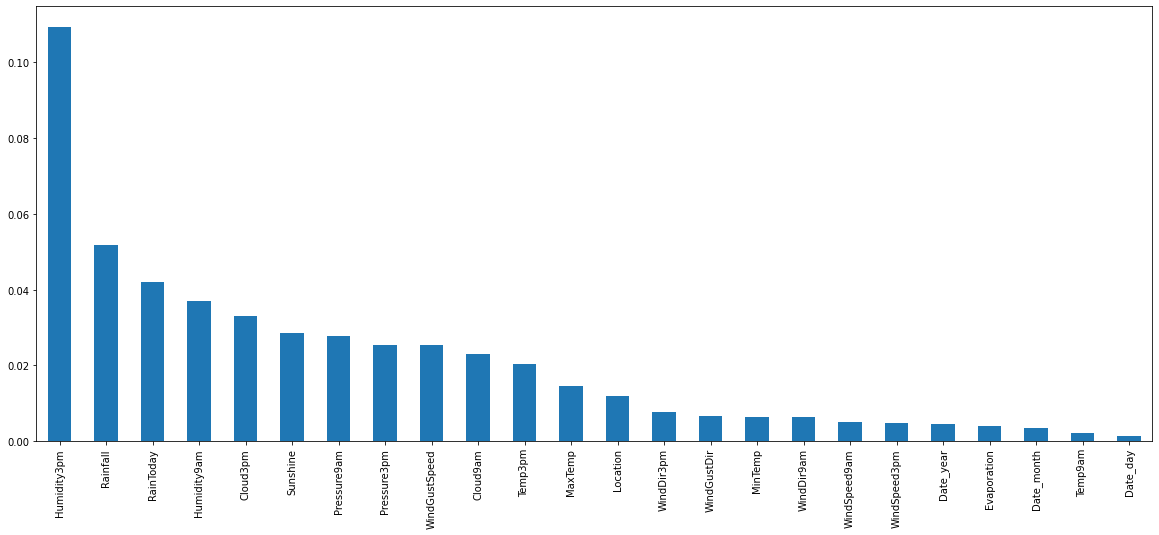

In [38]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [39]:
sel_five_cols = SelectKBest(mutual_info_classif, k=10)
sel_five_cols.fit(X_train, y_train)
X_train.columns[sel_five_cols.get_support()]

Index(['Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'RainToday'],
      dtype='object')

In [ ]:
df[X_train].to_csv("preprocessed4.csv")